In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder,FunctionTransformer
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV,ParameterGrid
from sklearn.metrics import fbeta_score
from sklearn.linear_model import RidgeClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgboost
import warnings
from joblib import dump, load
import shap
from random import seed
from random import sample
from sklearn.metrics import confusion_matrix
import seaborn as sns
shap.initjs() # required for visualizations later on
warnings.filterwarnings("ignore")

In [44]:
data = pd.read_csv("BankChurners.csv")
data.head()
#there are 20 features and 10127 data points

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

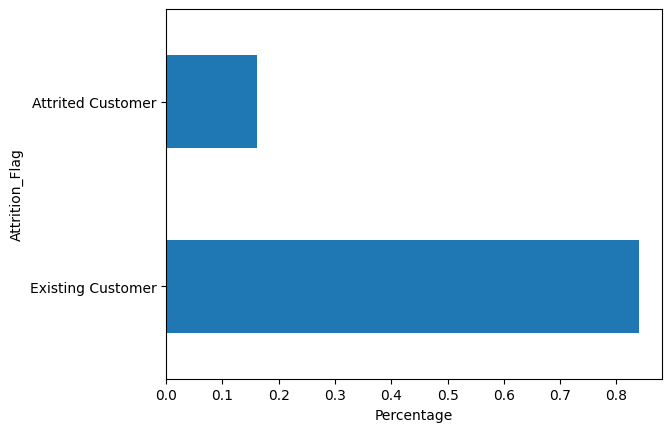

In [107]:
pd.value_counts(data['Attrition_Flag'],normalize=True).plot.barh()
plt.xlabel("Percentage")
plt.ylabel("Attrition_Flag")
plt.savefig(f'figures/target.png', bbox_inches='tight', dpi=300)
plt.show()

In [46]:
print(data.shape)

(10127, 21)


'CLIENTNUM' represents the unique client number assigned to each customer holding an account.

<Axes: >

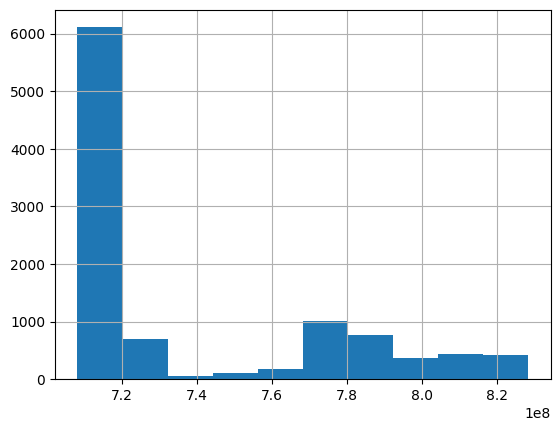

In [47]:
data['CLIENTNUM'].hist()

In [48]:
len(data['CLIENTNUM'].unique())

10127

### Demographic variables

'Customer_Age' is a demographic variable that quantifies the age of the customer in years. It is a continuous numerical attribute and is approximately normally distributed.

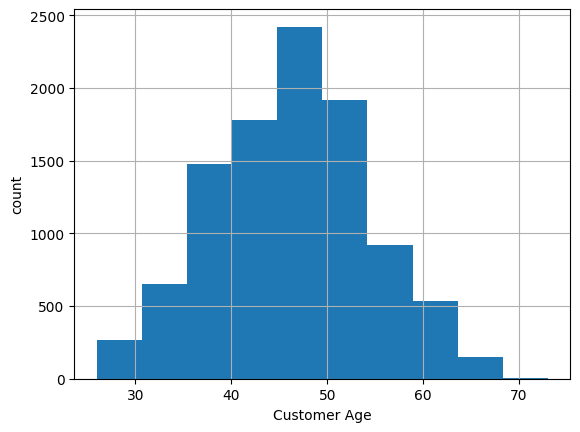

In [49]:
data['Customer_Age'].hist()
plt.xlabel("Customer Age")
plt.ylabel('count')
plt.show()

'Gender' is a demographic variable where 'F' denotes female and 'M' denotes male. This categorical feature, lacking any inherent order, exhibits a relatively balanced distribution.

In [50]:
data['Gender'].value_counts()/data.shape[0]

Gender
F    0.529081
M    0.470919
Name: count, dtype: float64

'Dependent_count' indicates the total number of dependents associated with a customer. This attribute is a discrete numerical feature.

Text(0, 0.5, 'percentage')

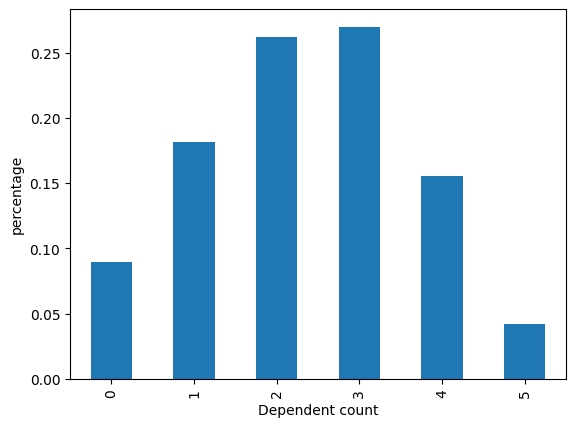

In [51]:
(data['Dependent_count'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("Dependent count")
plt.ylabel('percentage')

'Education_level' denotes the educational qualification of the account holder, which is an ordinal categorical feature. Its categories include 'Uneducated', 'High School', 'College', 'Graduate', 'Doctorate', 'Post-Graduate', and 'Unknown'. A significant portion of customers hold a graduate degree, while only a minority have post-graduate or doctorate qualifications. Notably, the 'Unknown' category represents missing data in this column, requiring attention during data preprocessing.

In [52]:
data['Education_Level'].value_counts()/data.shape[0]

Education_Level
Graduate         0.308877
High School      0.198776
Unknown          0.149995
Uneducated       0.146835
College          0.100030
Post-Graduate    0.050953
Doctorate        0.044534
Name: count, dtype: float64

'Marital_status' is a non-ordinal categorical feature with categories including 'Married', 'Single', 'Divorced', and 'Unknown'. The majority of customers fall into the 'Married' or 'Single' categories. This column also contains 'Unknown' values, which require appropriate handling during data preprocessing.

In [53]:
data['Marital_Status'].value_counts()/data.shape[0]

Marital_Status
Married     0.462822
Single      0.389355
Unknown     0.073961
Divorced    0.073862
Name: count, dtype: float64

'Income_Category' is an ordinal categorical feature, encompassing categories such as 'Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +', and 'Unknown'.

In [54]:
data['Income_Category'].value_counts()/data.shape[0]

Income_Category
Less than $40K    0.351634
$40K - $60K       0.176755
$80K - $120K      0.151575
$60K - $80K       0.138442
Unknown           0.109805
$120K +           0.071788
Name: count, dtype: float64

### Product Variable

'Card_Category' characterizes the types of cards held by customers. This is an ordinal categorical feature, including categories like 'Blue', 'Silver', 'Gold', and 'Platinum'.

In [55]:
data['Card_Category'].value_counts()/data.shape[0]

Card_Category
Blue        0.931767
Silver      0.054804
Gold        0.011455
Platinum    0.001975
Name: count, dtype: float64

'Months_on_book' indicates the duration of the customer's membership with the bank. This attribute is a continuous numerical feature and is approximately normally distributed.

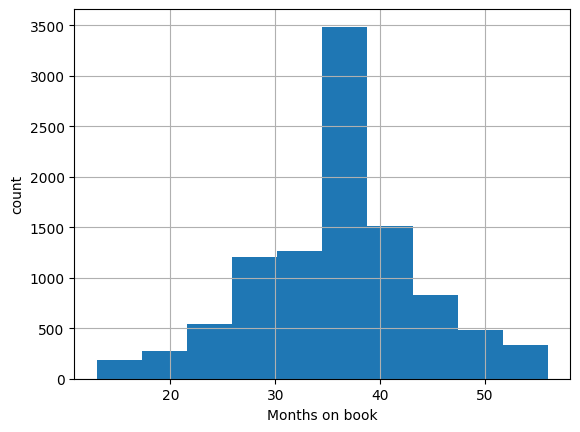

In [56]:
data['Months_on_book'].hist()
plt.xlabel('Months on book')
plt.ylabel('count')
plt.show()

Total_Relationship_Count' represents the total number of products a customer has with the bank. This attribute is a discrete numerical feature.

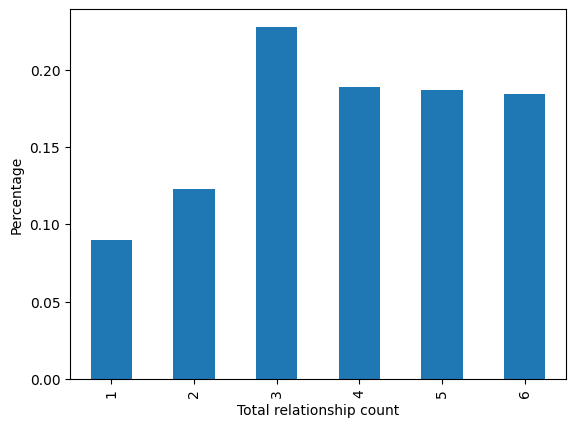

In [57]:
(data['Total_Relationship_Count'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("Total relationship count")
plt.ylabel("Percentage")
plt.show()

'Months_Inactive_12_mon' quantifies the number of inactive months a customer has had within the past 12 months. This is a discrete numerical attribute.

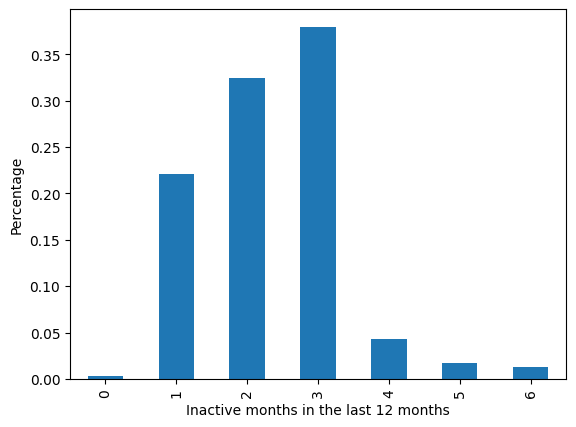

In [58]:
(data['Months_Inactive_12_mon'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("Inactive months in the last 12 months")
plt.ylabel("Percentage")
plt.show()

'Contacts_Count_12_mon' measures the frequency of interactions between the customer and the bank manager over the last 12 months. This attribute is a discrete numerical feature.

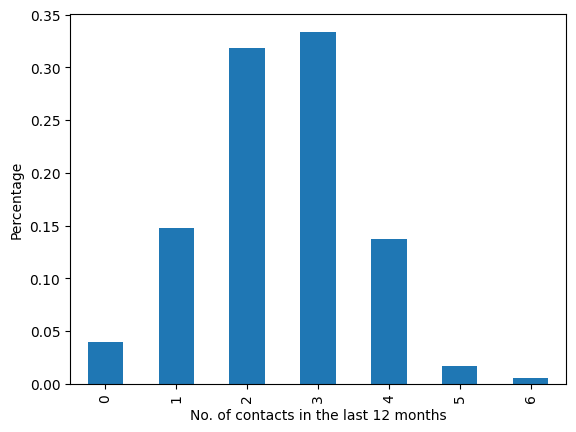

In [59]:
(data['Contacts_Count_12_mon'].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
plt.xlabel("No. of contacts in the last 12 months")
plt.ylabel("Percentage")
plt.show()

'Credit_Limit' is the limit on the credit card. It is a continuous numerical feature.

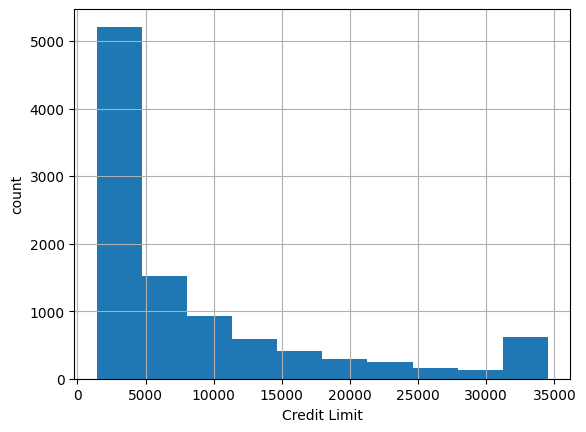

In [60]:
data['Credit_Limit'].hist()
plt.xlabel("Credit Limit")
plt.ylabel("count")
plt.show()

'Total_Revolving_Bal' is the total revolving balance on the credit card and it is a continuous numerical feature.

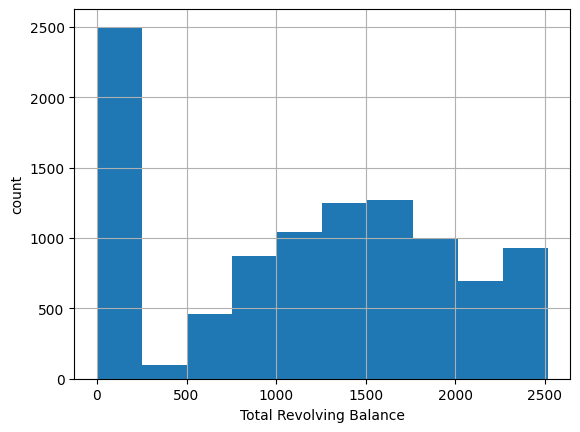

In [61]:
data['Total_Revolving_Bal'].hist()
plt.xlabel("Total Revolving Balance")
plt.ylabel("count")
plt.show()

 'Avg_Open_To_Buy' is the average amount left in the customer's credit card limit and is a continuous numerical feature. 

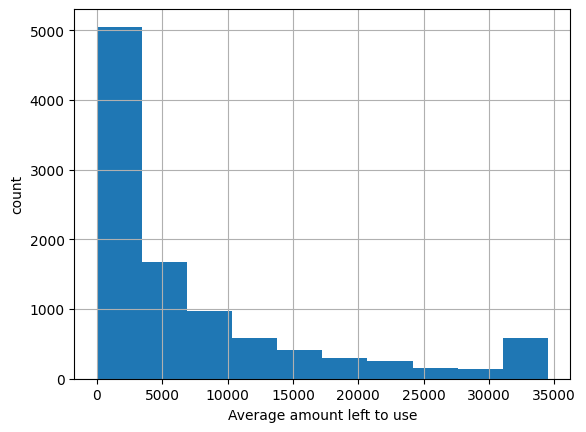

In [62]:
data['Avg_Open_To_Buy'].hist()
plt.xlabel("Average amount left to use")
plt.ylabel("count")
plt.show()

'Total_Amt_Chng_Q4_Q1' measures the change of the transaction amount from Q4 to Q1 and is a continuous numerical feature.

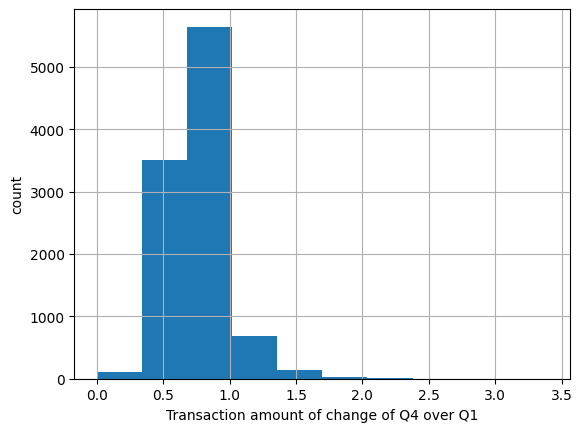

In [63]:
data['Total_Amt_Chng_Q4_Q1'].hist()
plt.xlabel("Transaction amount of change of Q4 over Q1")
plt.ylabel("count")
plt.show()

'Total_Trans_Amt' measures the total transaction amount over the last 12 months and is a continuous numerical feature. 

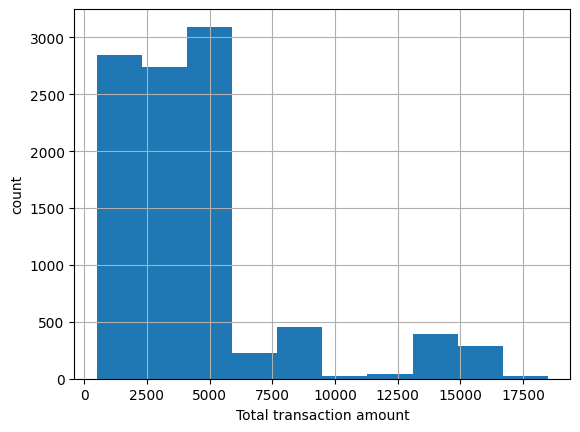

In [64]:
data['Total_Trans_Amt'].hist()
plt.xlabel("Total transaction amount")
plt.ylabel("count")
plt.show()

'Total_Trans_Ct' counts the total number of transactions over the last 12 months and is a continuous numerical feature. 

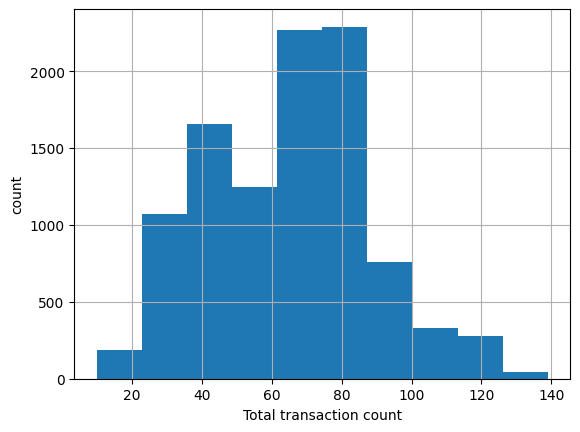

In [65]:
data['Total_Trans_Ct'].hist()
plt.xlabel("Total transaction count")
plt.ylabel("count")
plt.show()

'Total_Ct_Chng_Q4_Q1' measures the difference in transaction count from Q4 to Q1 and is a continuous numerical feature.

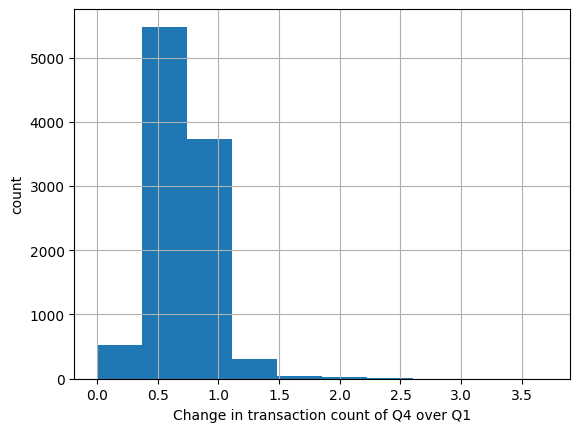

In [66]:
data['Total_Ct_Chng_Q4_Q1'].hist()
plt.xlabel("Change in transaction count of Q4 over Q1")
plt.ylabel("count")
plt.show()

'Avg_Utilization_Ratio' calculates the average card utilization ratio, defined as the sum of credit card spending and money withdrawals divided by the total available limit for credit card spending and total money withdrawal limit. This metric is a continuous numerical feature.

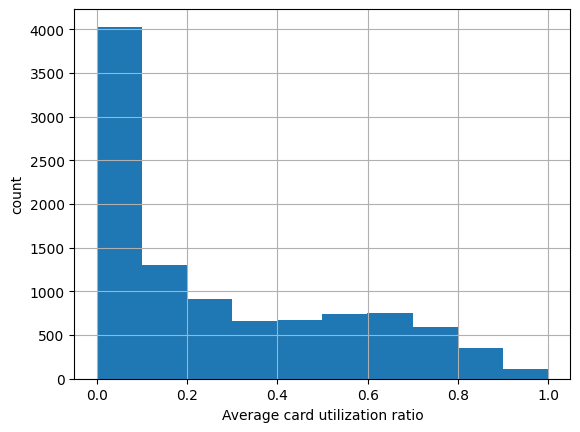

In [67]:
data['Avg_Utilization_Ratio'].hist()
plt.xlabel("Average card utilization ratio")
plt.ylabel("count")
plt.show()

# EDA

In [68]:
con_fea = ['CLIENTNUM','Customer_Age','Months_on_book','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1',
           'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
dis_fea = ['Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon',]
cat_fea = ['Gender','Marital_Status']
ord_fea = ['Education_Level','Income_Category','Card_Category']
categories = data['Attrition_Flag'].unique()

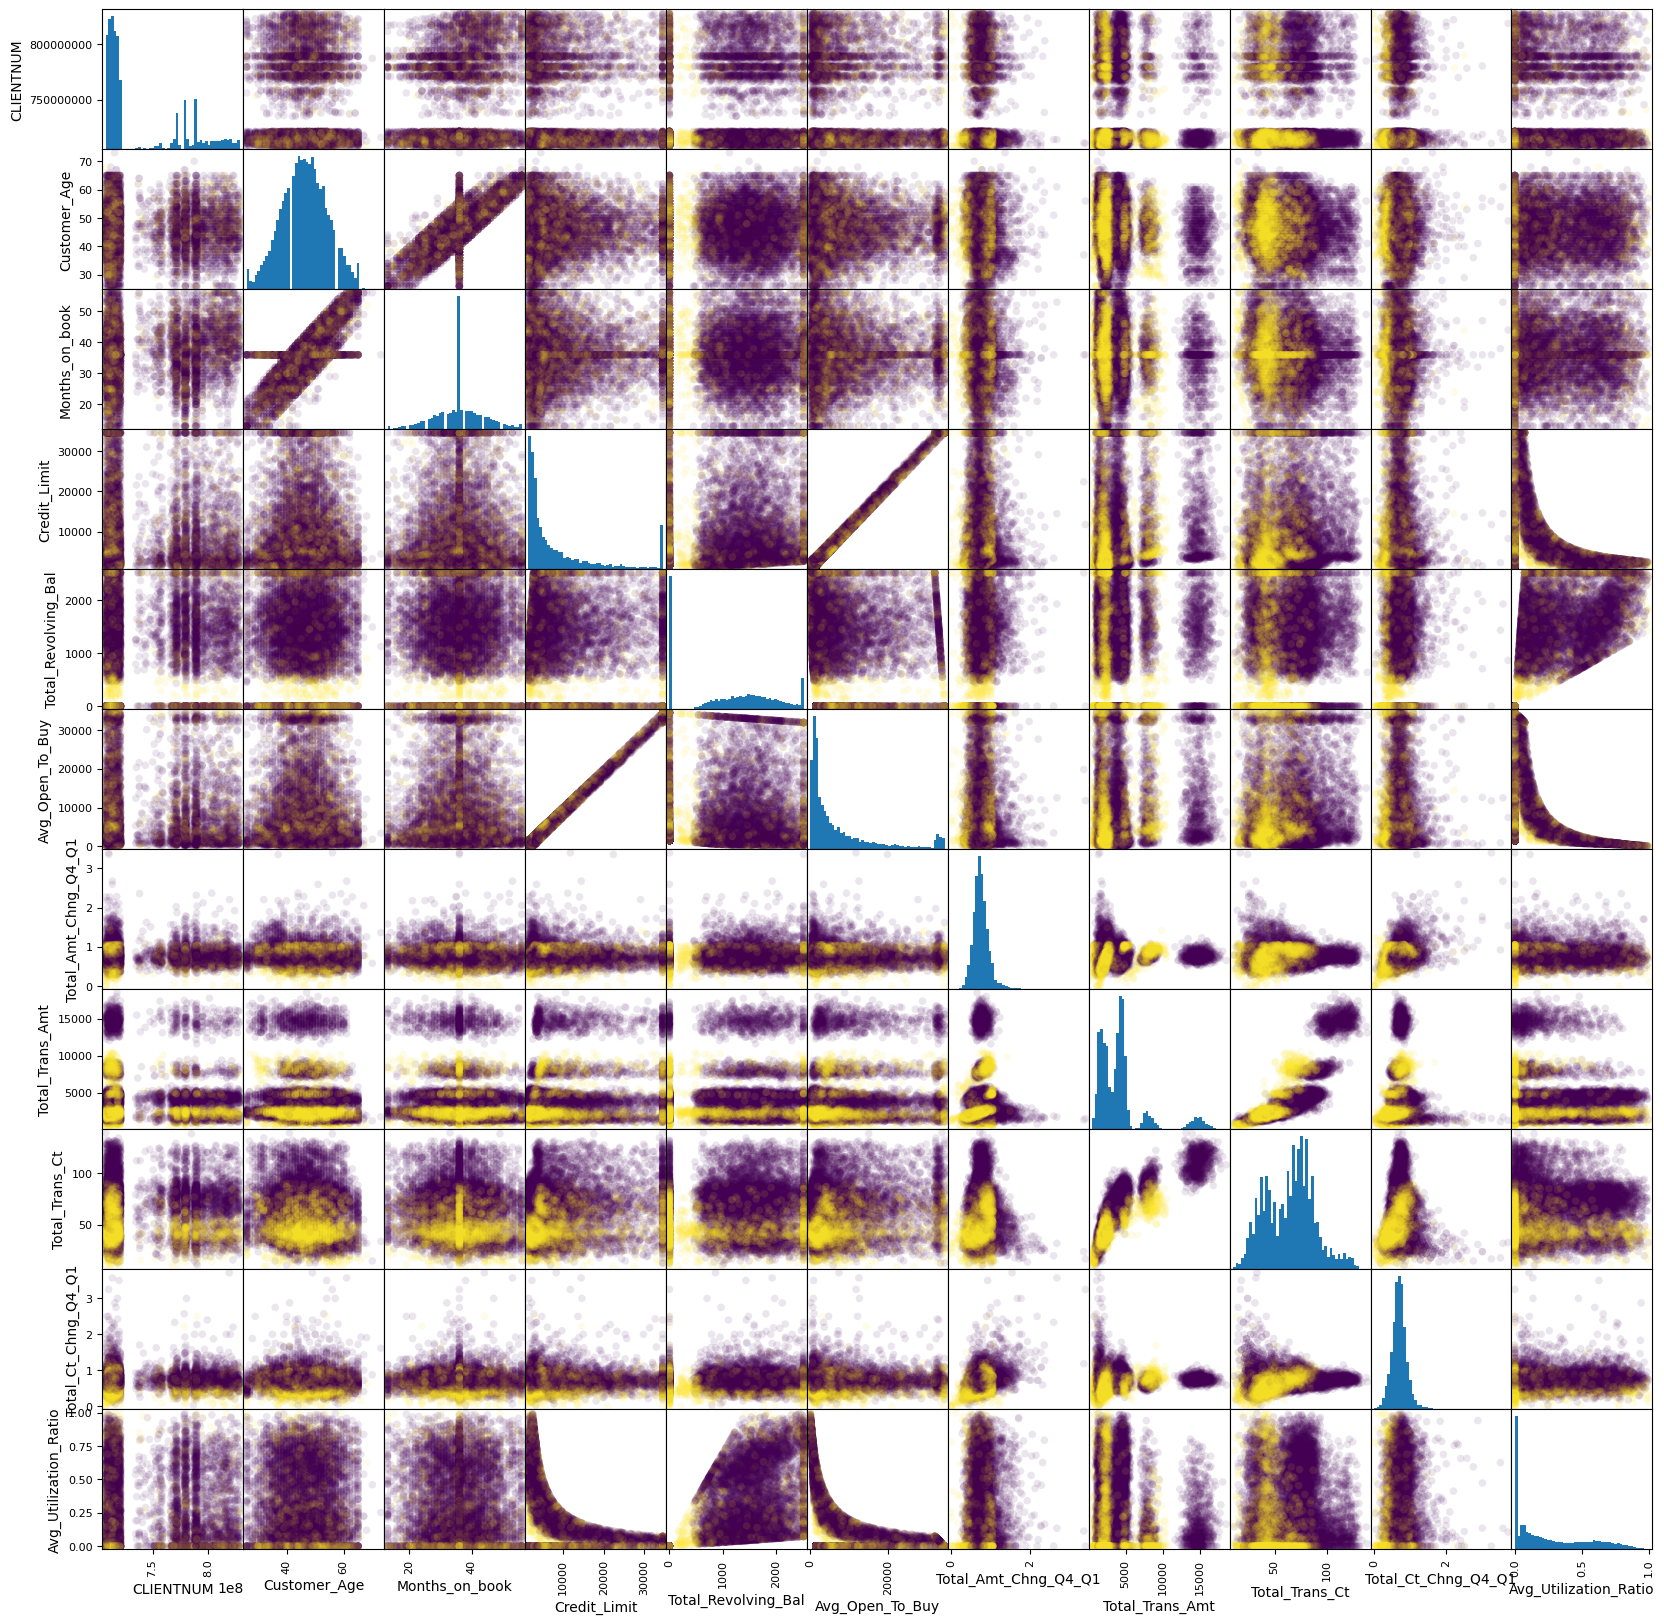

In [108]:
pd.plotting.scatter_matrix(data[con_fea], figsize=(20, 20), marker='o',hist_kwds={'bins': 50}, 
                           c = pd.get_dummies(data['Attrition_Flag']).iloc[:,0],s=30, alpha=.1)
plt.savefig(f'figures/correlation_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

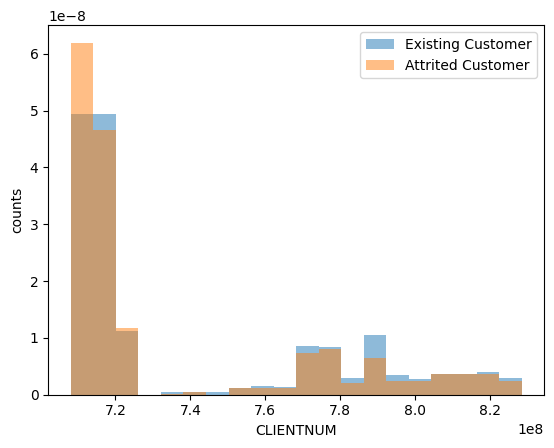

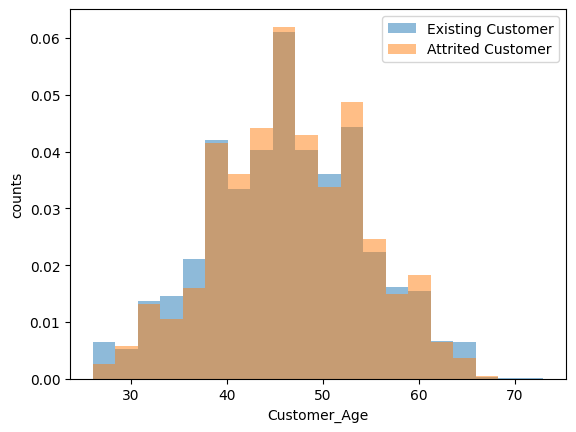

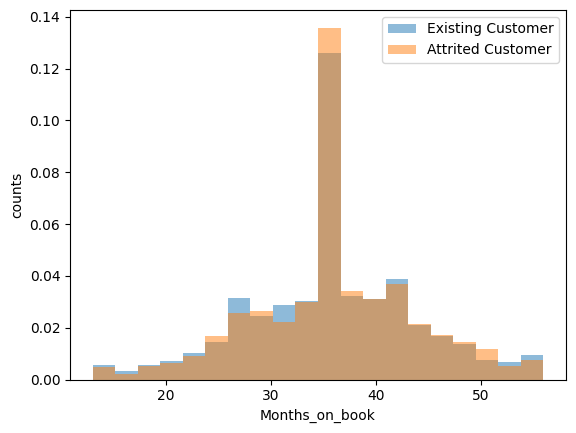

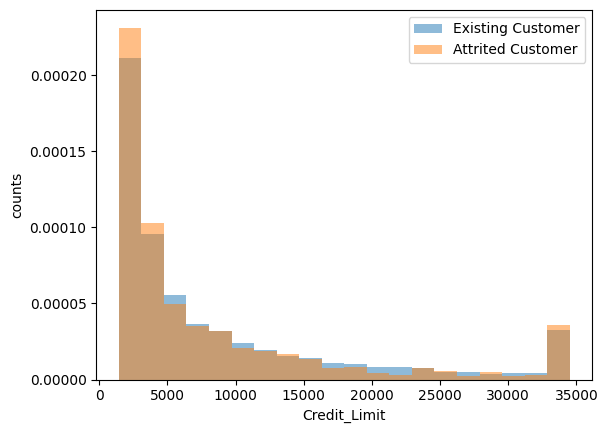

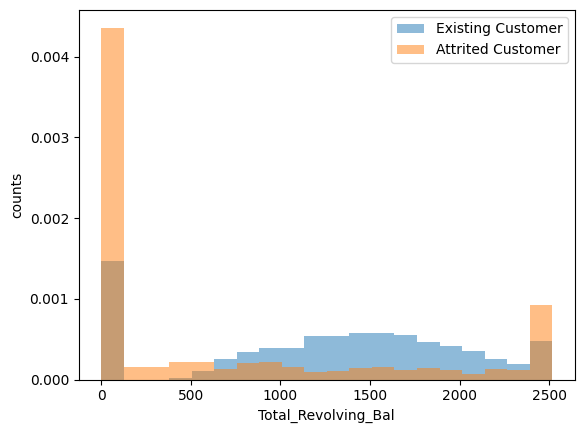

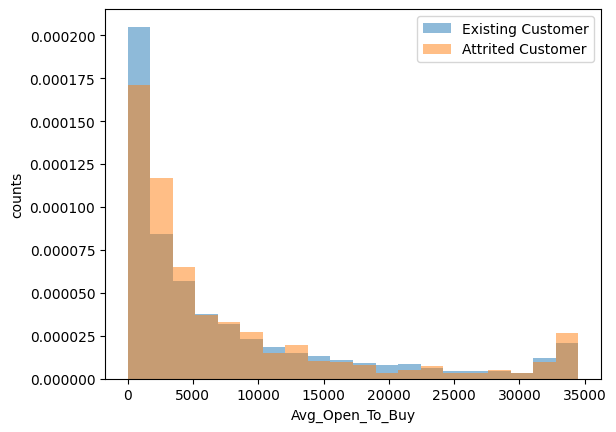

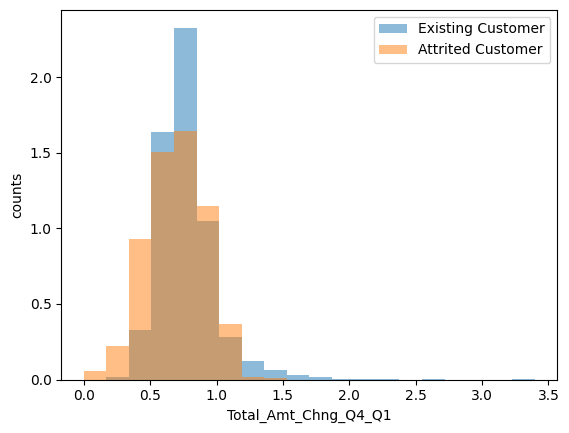

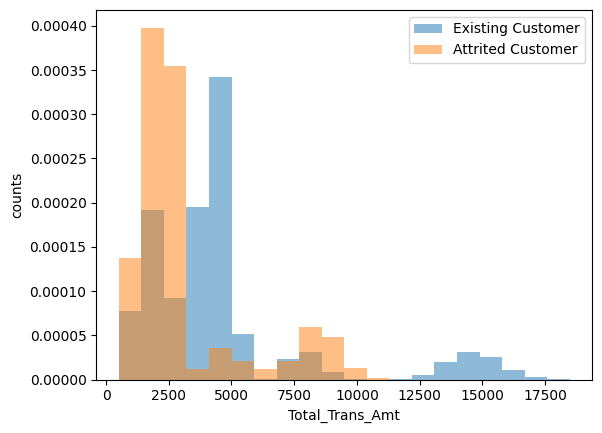

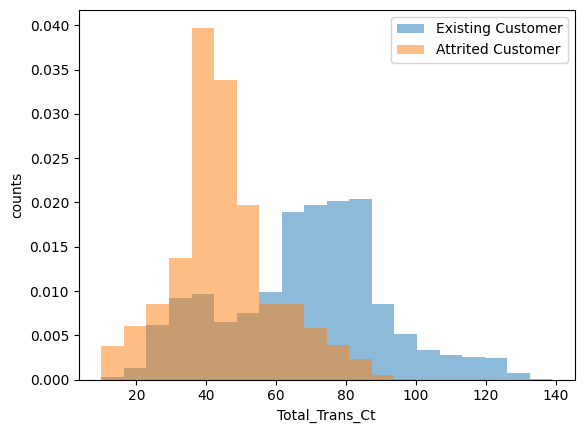

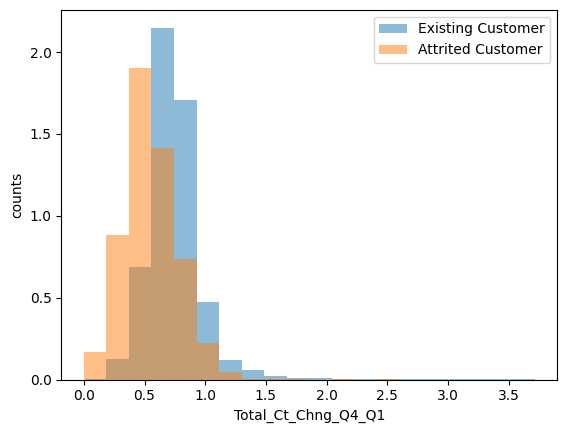

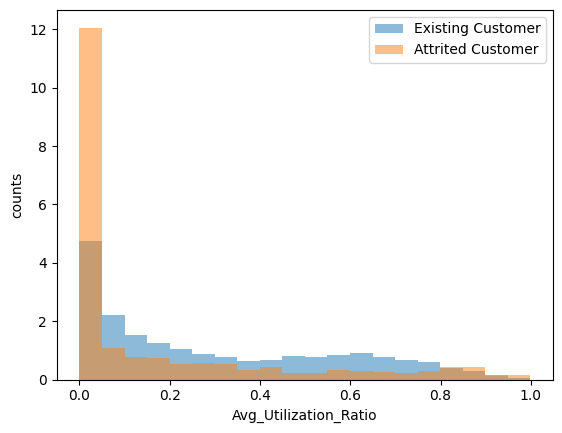

In [110]:
for feature in con_fea:
    bin_range = (data[feature].min(),data[feature].max())
    for c in categories:
        plt.hist(data[data['Attrition_Flag']==c][feature],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
    plt.legend()
    plt.ylabel('counts')
    plt.xlabel(feature)
    plt.savefig(f'figures/{feature}.png', bbox_inches='tight', dpi=300)
    plt.show()

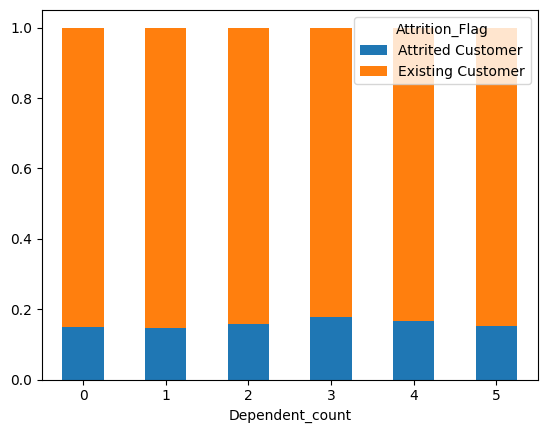

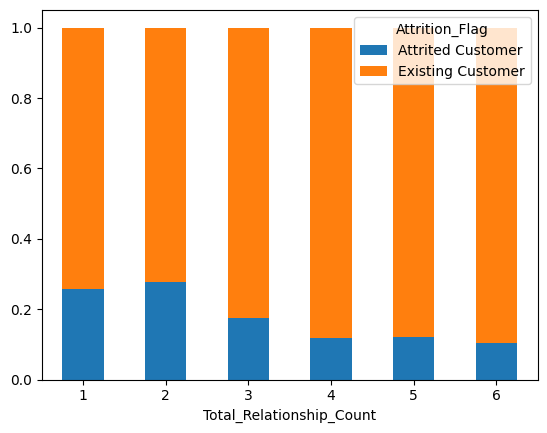

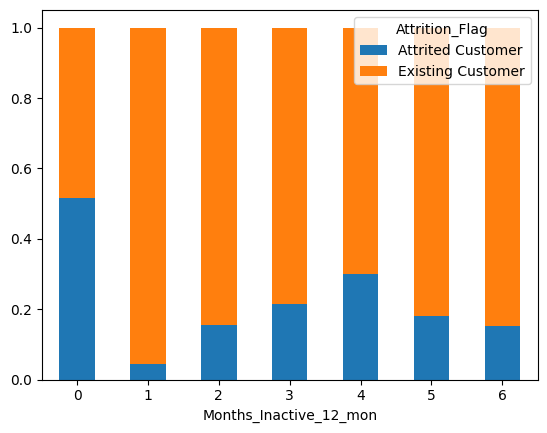

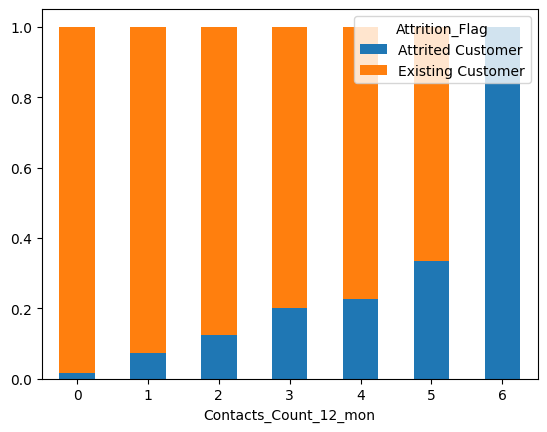

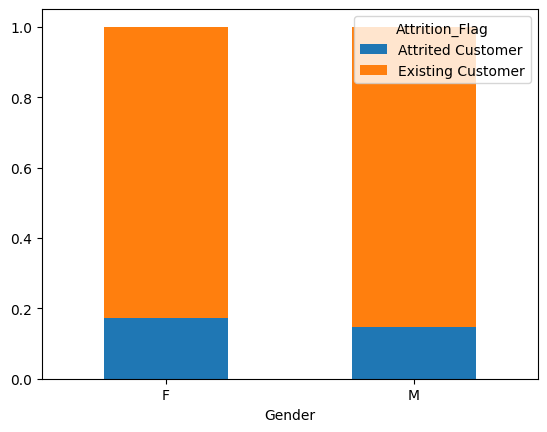

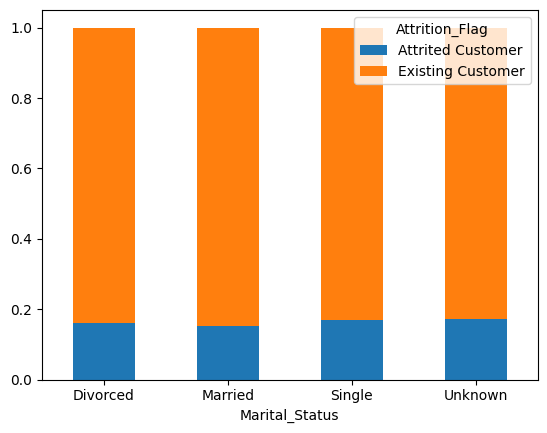

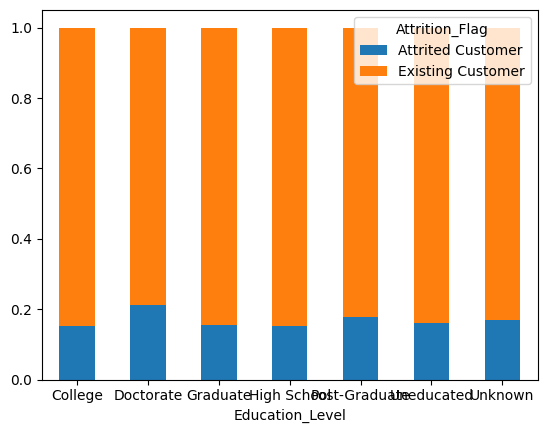

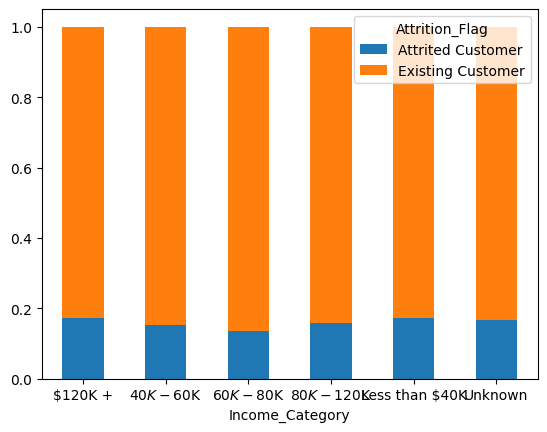

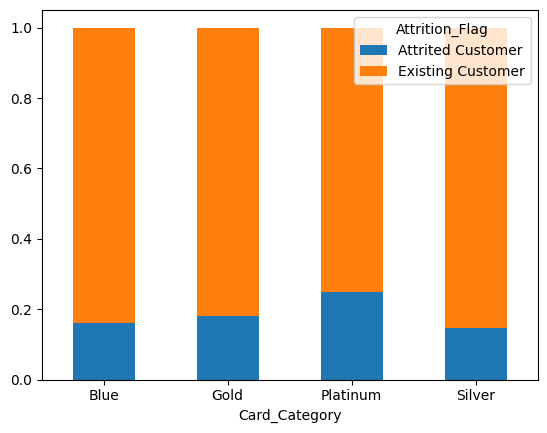

In [111]:
for feature in dis_fea+cat_fea+ord_fea:
    count_matrix = data.groupby([feature, 'Attrition_Flag']).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True)
    plt.xticks(rotation=0)
    plt.savefig(f'figures/{feature}.png', bbox_inches='tight', dpi=300)
    plt.show()

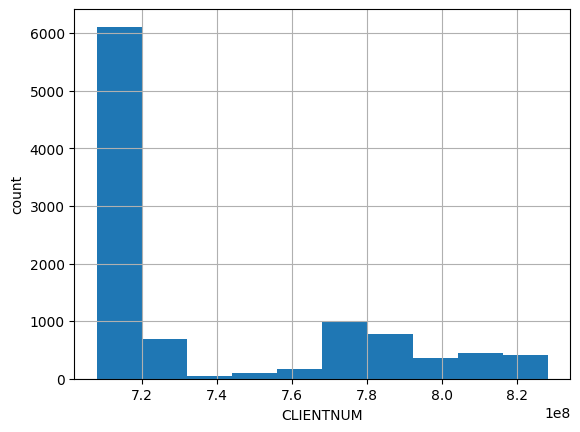

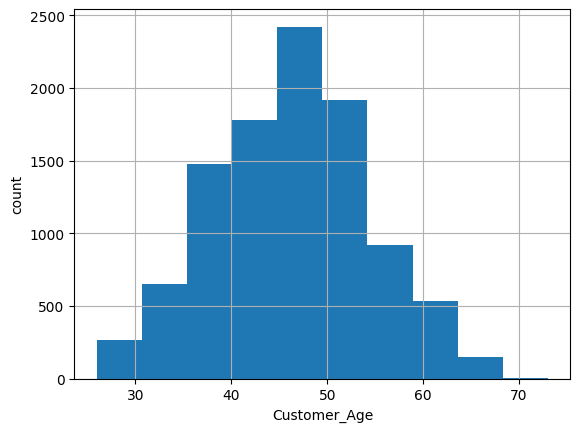

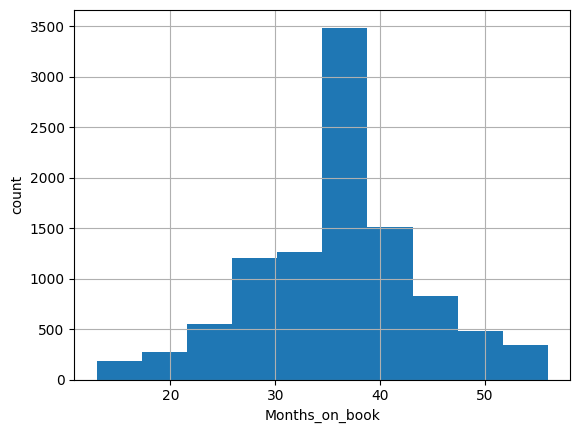

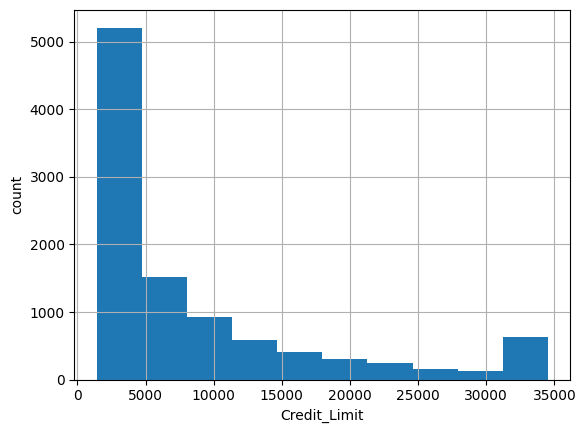

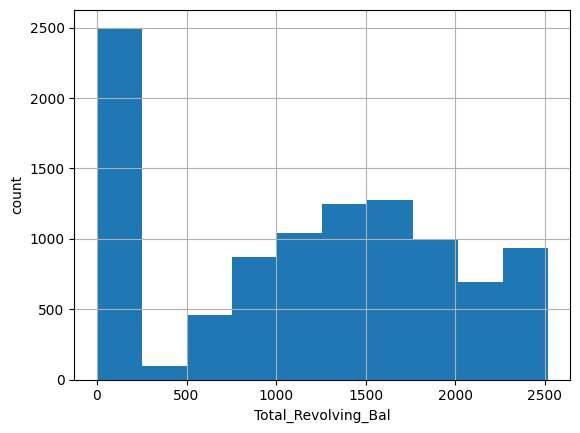

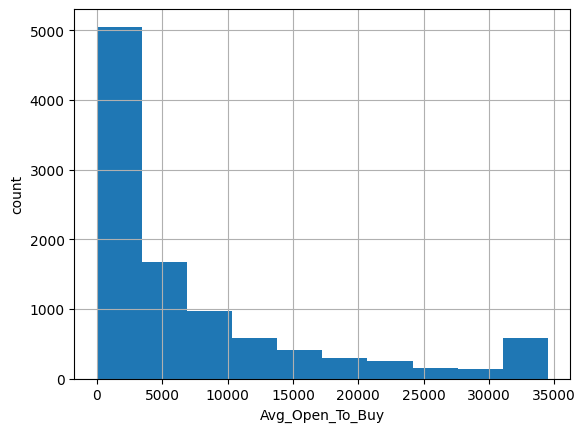

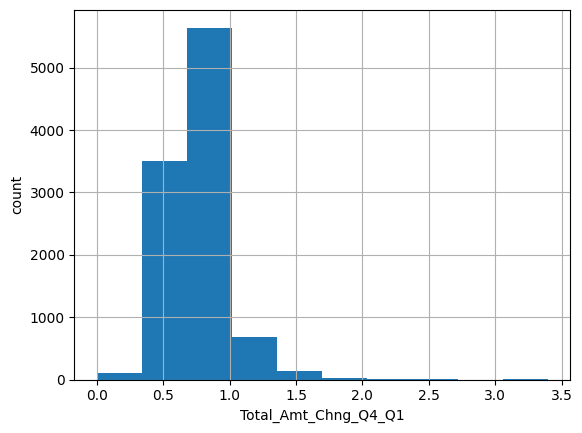

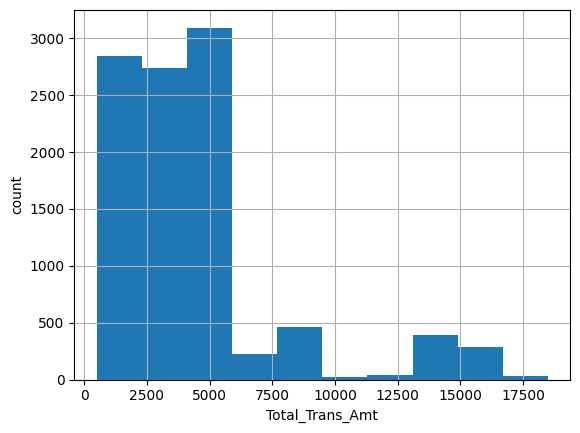

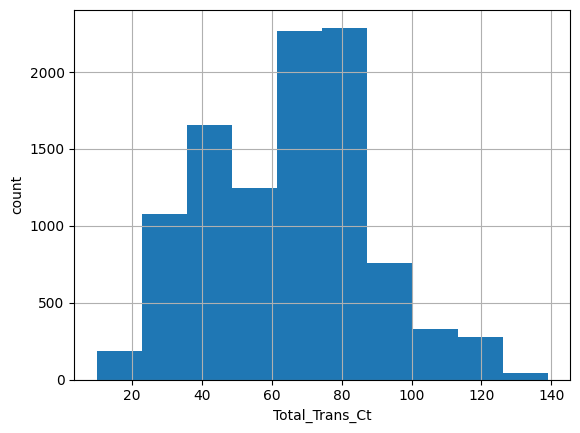

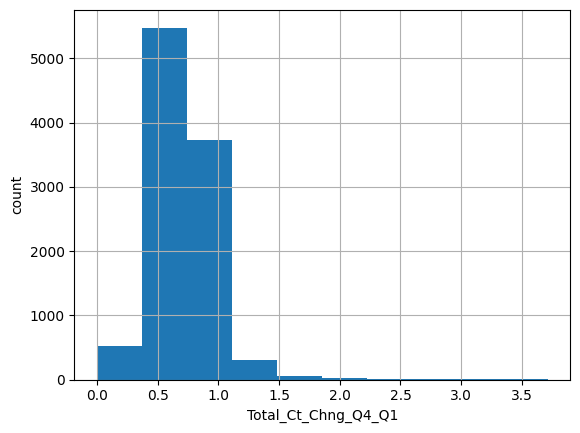

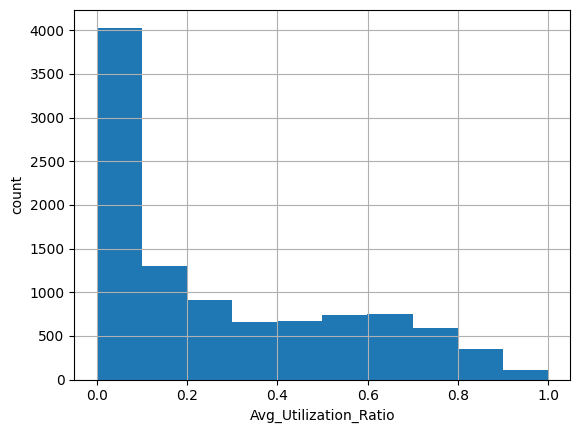

In [72]:
for feature in con_fea:
    data[feature].hist()
    plt.xlabel(feature)
    plt.ylabel('count')
    plt.show()

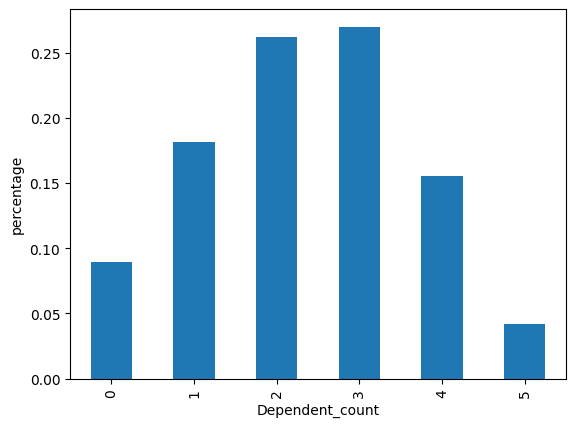

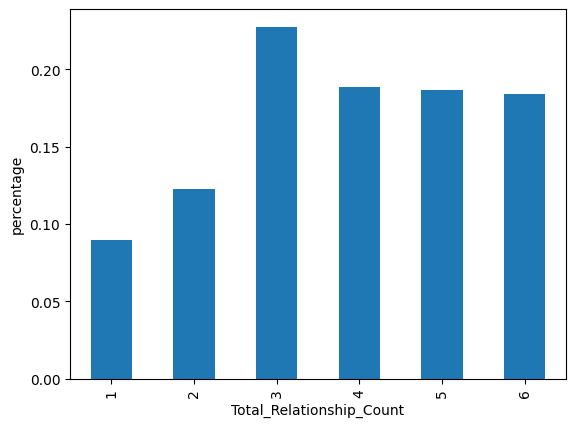

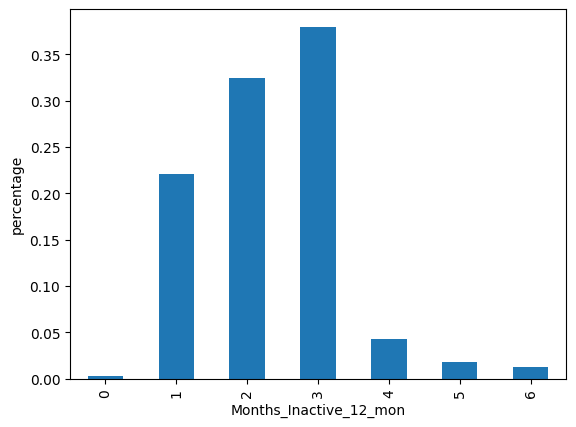

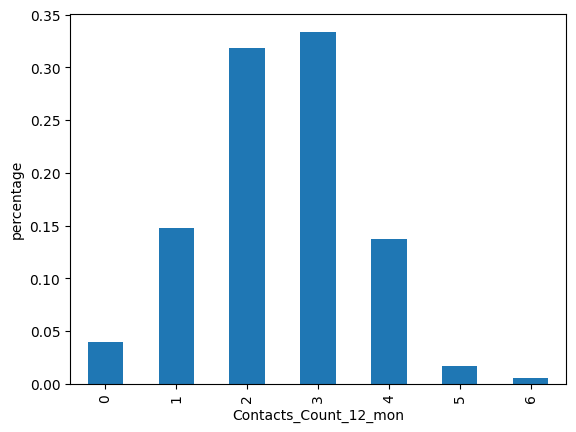

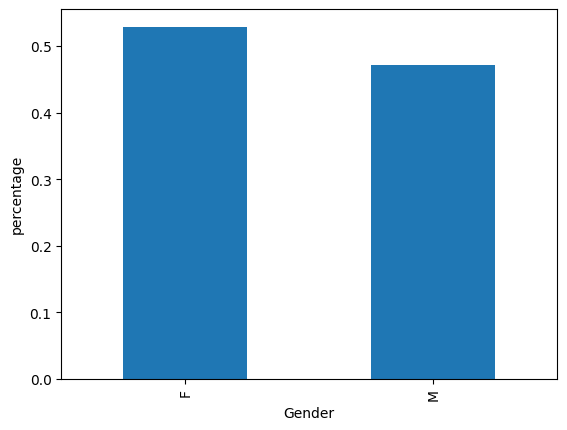

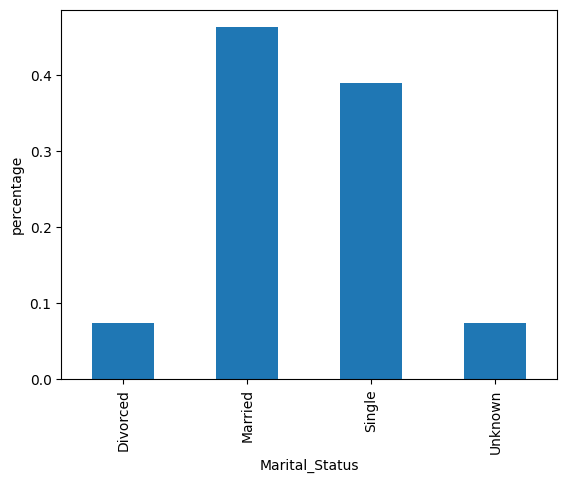

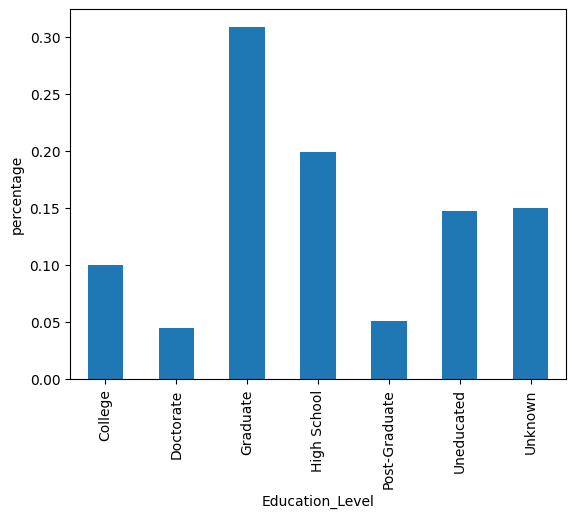

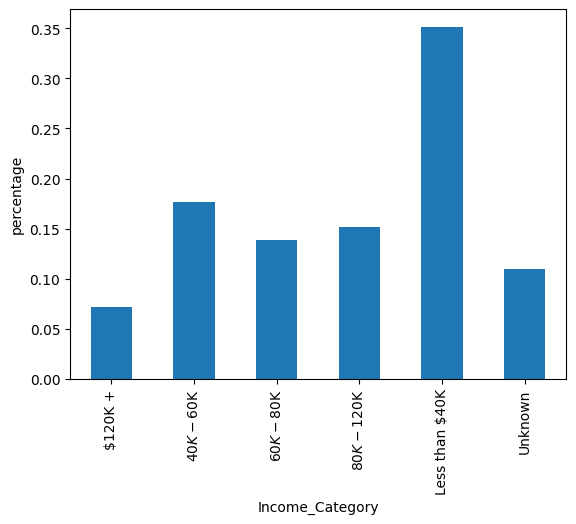

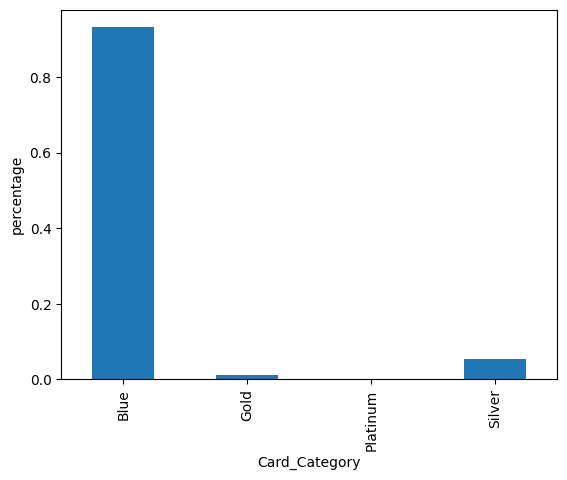

In [73]:
for feature in dis_fea+cat_fea+ord_fea:
    (data[feature].value_counts()/data.shape[0]).sort_index().plot(kind = 'bar')
    plt.xlabel(feature)
    plt.ylabel('percentage')
    plt.show()

# Methods

In [74]:
X = data[[column for column in data.columns if column != 'Attrition_Flag']]
y = np.where(data['Attrition_Flag'] == "Existing Customer", 0, 1)


con_fea = ['CLIENTNUM','Customer_Age','Months_on_book','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1',
           'Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
dis_fea = ['Dependent_count','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon',]
cat_fea = ['Gender','Marital_Status']
ord_fea = ['Education_Level','Income_Category','Card_Category']
ord_cats =[['Uneducated','High School','College','Graduate','Doctorate','Post-Graduate','Unknown'],
           ['Less than $40K', '$40K - $60K','$60K - $80K','$80K - $120K','$120K +','Unknown'], 
           ['Blue','Silver','Gold','Platinum']
          ]

ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories = ord_cats))])
onehot_transformer = Pipeline(steps = [('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
def fun(x):
    return x   
no_transformer = FunctionTransformer(fun)


preprocessor = ColumnTransformer(
    transformers=[
        ('ord', ordinal_transformer, ord_fea),
        ('cat', onehot_transformer, cat_fea),
        ('num', numeric_transformer, con_fea),
        ('dis',no_transformer,dis_fea)
        ]
)

X_prep = preprocessor.fit_transform(X)

In [131]:
X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = 0,stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state = 0,stratify=y_other)
print(X_train.shape)
X_train_prep = preprocessor.fit_transform(X_train)
X_val_prep = preprocessor.transform(X_val)
X_test_prep = preprocessor.transform(X_test)
print(X_train_prep.shape)
print(X_val_prep.shape)
print(X_test_prep.shape)

(6076, 20)
(6076, 24)
(2026, 24)
(2025, 24)


**XGBoost**

In [75]:
final_model_xgboost = []
n_state = 5

test_scores_xgboost = np.zeros(n_state)
    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                    "n_estimators": [10000],
                    "min_child_weight": [1,3,5,7],
                    "gamma": [0,0.1,0.2,0.3,0.4],
                    "max_depth":  [2],
                    "colsample_bytree": [0.3,0.4,0.5,0.7,1],              
                    "subsample": [0.5,0.66,0.75,1]
                 }

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        eval_set = [(X_val_prep, y_val)]
        clf = xgboost.XGBClassifier(**params,random_state=state,use_label_encoder=False,eval_metric = "logloss")
        clf.fit(X_train_prep,y_train,early_stopping_rounds=50,verbose = False, eval_set=eval_set)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_xgboost.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_xgboost[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_xgboost[i]))

random_states = 0
    {'subsample': 0.5, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9295600082627555 and the validation score: 0.866043613707165
    {'subsample': 0.66, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.9581702039975273 and the validation score: 0.8799751243781094
    {'subsample': 0.75, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.944467382328654 and the validation score: 0.8724202626641653
    {'subsample': 1, 'n_estimators': 10000, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.3}
   the traning score is 0.947618065580532 and the validation score: 0.8713304184884448
    {'subsample': 0.5, 'n_estimators': 10000, 'min_ch

**SVM**

In [76]:
final_models_svm = []
n_state = 5

test_scores_svm = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = [0.001,0.01,0.1,1,10,100,1000]
    gamma_list = [0.001,0.01,0.1,1,10,100,1000]
    # find the best parameter set
    param_grid = {"C":C_list,"gamma":gamma_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = SVC(**params,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
            
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_models_svm.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_svm[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_svm[i]))


random_states = 0
    {'gamma': 0.001, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.1, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 10, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 100, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1000, 'C': 0.001}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.001, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.01, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 0.1, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {'gamma': 1, 'C': 0.01}
   the traning score is 0.0 and the validation score: 0.0
    {

**RandomForest**

In [77]:
final_model_rf = []
n_state = 5

test_scores_rf = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    
    max_depth_list = [1,2,3,5,10,15,20,30,50]
    max_features_list = [2,5,10,15,20]
    # find the best parameter set
    param_grid = {"max_depth":max_depth_list,"max_features":max_features_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = RandomForestClassifier(**params,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_rf.append(best_model)
    
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_rf[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_rf[i]))

random_states = 0
    {'max_features': 2, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 10, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 15, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 20, 'max_depth': 1}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 2, 'max_depth': 2}
   the traning score is 0.0 and the validation score: 0.0
    {'max_features': 5, 'max_depth': 2}
   the traning score is 0.13695219123505975 and the validation score: 0.10142749812171299
    {'max_features': 10, 'max_depth': 2}
   the traning score is 0.40735567970204845 and the validation score: 0.3759662684469431
    {'max_features': 15, 'max_depth': 2}
   the traning score is 0.5350877192982456 and the validation score: 0.5123087159015303
  

**ElasticNet**

In [78]:
final_model_elasticnet = []
n_state = 5

test_scores_elasticnet = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    C_list = np.logspace(-5,5,num = 10)
    l1_ratio_list = [0.1,0.3,0.5,0.7,0.9]
    # find the best parameter set
    param_grid = {"C":C_list,"l1_ratio":l1_ratio_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='elasticnet',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_elasticnet.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_elasticnet[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best params are {}, and the test score is {} \n '.format(best_params,test_scores_elasticnet[i]))

random_states = 0
    {'l1_ratio': 0.1, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.3, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.5, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.7, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.9, 'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.1, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.3, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.5, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.7, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'l1_ratio': 0.9, 'C': 0.0001291549665014884}
   the traning score is 0.0 and the vali

**Lasso Classifier**

In [79]:
final_model_lasso = []
n_state = 5

test_scores_lasso = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = np.logspace(-5,5,10)
    # find the best parameter set
    param_grid = {"C":C_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='l1',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))
       
        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_lasso.append(best_model)
    # test the model on the test set with best parameter set
    
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_lasso[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best C is {}, and the test score is {} \n '.format(best_params,test_scores_lasso[i]))


random_states = 0
    {'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0016681005372000592}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.021544346900318846}
   the traning score is 0.5486998677831644 and the validation score: 0.5194369973190348
    {'C': 0.2782559402207126}
   the traning score is 0.6154672395273899 and the validation score: 0.5977907732293697
    {'C': 3.593813663804626}
   the traning score is 0.6223221936589546 and the validation score: 0.603112840466926
    {'C': 46.41588833612782}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 599.4842503189421}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 7742.636826811277}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 100000.0}
   

**RidgeClassifier**

In [80]:
final_model_ridge = []
n_state = 5

test_scores_ridge = np.zeros(n_state)

    
for i in range(n_state):
    state = 42*i
    print("random_states = %i"%(state))
    
    #split the data to 60-20-20
    X_train,X_other,y_train,y_other = train_test_split(X,y,train_size = 0.6,random_state = state,stratify=y)
    X_test, X_val, y_test, y_val = train_test_split(X_other,y_other,train_size = 0.5,random_state=state,stratify=y_other)
    
    # preprocess the sets
    X_train_prep = preprocessor.fit_transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    
    C_list = np.logspace(-5,5,10)
    # find the best parameter set
    param_grid = {"C":C_list}

    pg = ParameterGrid(param_grid)
    train_score = np.zeros(len(pg))
    val_score = np.zeros(len(pg))
    models = []

    for j in range(len(pg)):
        params = ParameterGrid(param_grid)[j]
        print('   ',params) 
        
        clf = LogisticRegression(**params,penalty='l2',solver='saga',max_iter=5000,random_state=state)
        clf.fit(X_train_prep,y_train)
        models.append(clf)

        y_train_pred = clf.predict(X_train_prep)
        y_val_pred = clf.predict(X_val_prep)
        train_score[j] = fbeta_score(y_train,y_train_pred,beta = 2.0)
        val_score[j] = fbeta_score(y_val,y_val_pred,beta = 2.0)
        #Print out the train and validation scores for each alpha in linreg_model
        print("   the traning score is {} and the validation score: {}".format(train_score[j], val_score[j]))

        
    best_params = np.array(pg)[val_score == np.max(val_score)]
    best_model = models[np.argmax(val_score)]
    final_model_ridge.append(best_model)
    # test the model on the test set with best parameter set
    y_test_pred = best_model.predict(X_test_prep)
    test_scores_ridge[i] = fbeta_score(y_test,y_test_pred,beta = 2.0)

    print('The best alpha is {}, and the test score is {} \n '.format(best_params,test_scores_ridge[i]))

random_states = 0
    {'C': 1e-05}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0001291549665014884}
   the traning score is 0.0 and the validation score: 0.0
    {'C': 0.0016681005372000592}
   the traning score is 0.3484237971083195 and the validation score: 0.3118279569892473
    {'C': 0.021544346900318846}
   the traning score is 0.5605726872246695 and the validation score: 0.5210420841683367
    {'C': 0.2782559402207126}
   the traning score is 0.6098085609808561 and the validation score: 0.5928338762214984
    {'C': 3.593813663804626}
   the traning score is 0.6224555388900793 and the validation score: 0.603112840466926
    {'C': 46.41588833612782}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 599.4842503189421}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840466926
    {'C': 7742.636826811277}
   the traning score is 0.6221889055472265 and the validation score: 0.603112840

# Results

In [81]:
# Baseline:
y_pred = np.ones(len(y))
f2 = fbeta_score(y,y_pred,beta = 2.0)
print(f2)

0.489029155395251


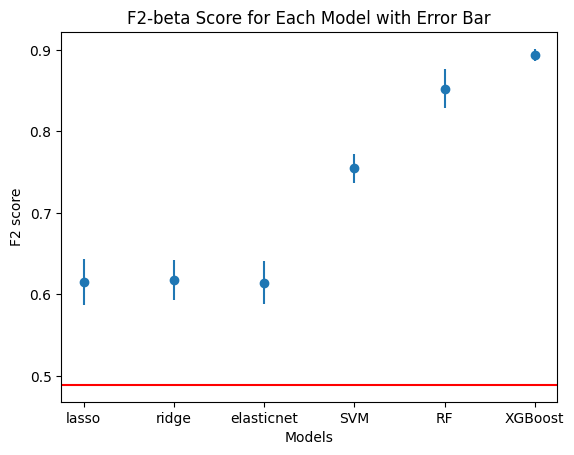

In [112]:
model_name = ["lasso","ridge","elasticnet","SVM", "RF","XGBoost"]

test_scores = [test_scores_lasso,test_scores_ridge,test_scores_elasticnet,test_scores_svm,test_scores_rf,test_scores_xgboost]
mean_list = [np.mean(score) for score in test_scores]
std_list = [np.std(score) for score in test_scores]


plt.errorbar(model_name,mean_list,yerr=std_list,label = "f2 score",fmt = "o")
plt.axhline(y=f2, color='r', linestyle='-')
plt.xlabel("Models")
plt.ylabel("F2 score")
plt.title("F2-beta Score for Each Model with Error Bar")
plt.savefig(f"figures/F2_beta.png", bbox_inches='tight', dpi=300)
plt.show()

In [83]:
df = pd.DataFrame({
    'Lasso Logistic Regression': test_scores_lasso,
    'Ridge Logistic Regression': test_scores_ridge,
    'SVM': test_scores_svm,
    'Random Forest': test_scores_rf,
    'XGBoost': test_scores_xgboost
})

df_summary = df.agg(['mean', 'std']).T
df_summary['F2 Beta Score (Mean ± Std)'] = df_summary['mean'].round(3).astype(str) + " ± " + df_summary['std'].round(3).astype(str)

df_summary.drop(['mean', 'std'], axis=1, inplace=True)

df_summary.reset_index(inplace=True)
df_summary.rename(columns={'index': 'Model'}, inplace=True)


baseline_row = pd.DataFrame([['Baseline', '0.489']], columns=['Model', 'F2 Beta Score (Mean ± Std)'])
df_final = pd.concat([df_summary, baseline_row], ignore_index=True)

df_final

Model F2 Beta Score (Mean ± Std)
0  Lasso Logistic Regression              0.616 ± 0.031
1  Ridge Logistic Regression              0.618 ± 0.027
2                        SVM               0.755 ± 0.02
3              Random Forest              0.853 ± 0.027
4                    XGBoost              0.894 ± 0.008
5                   Baseline                      0.489

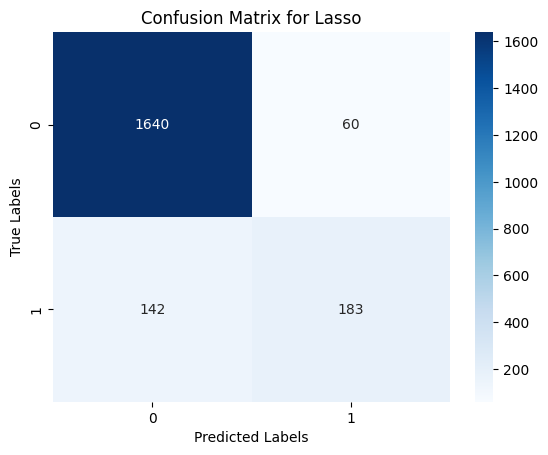

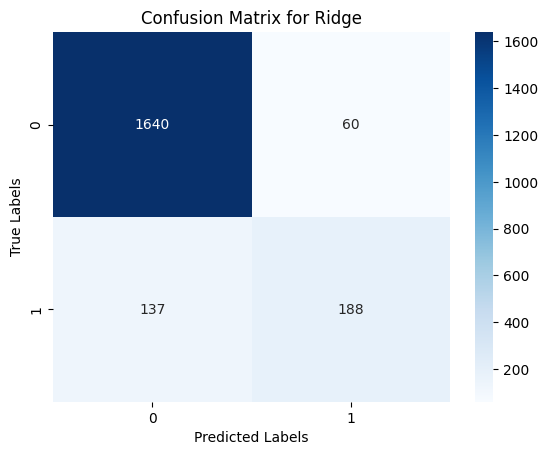

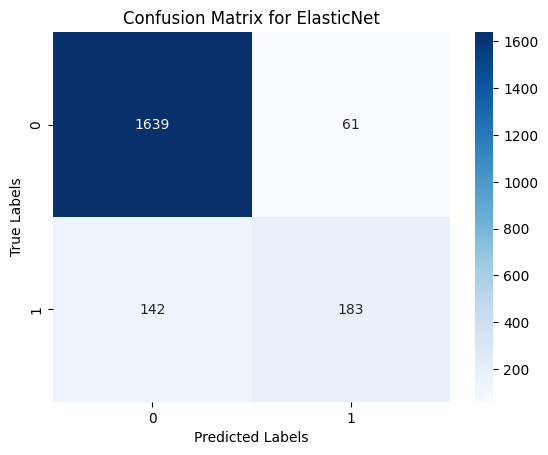

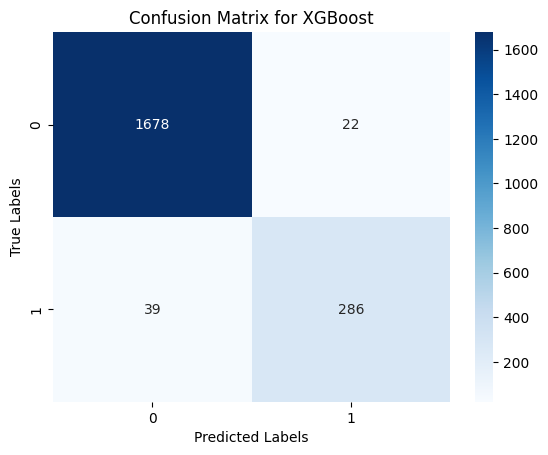

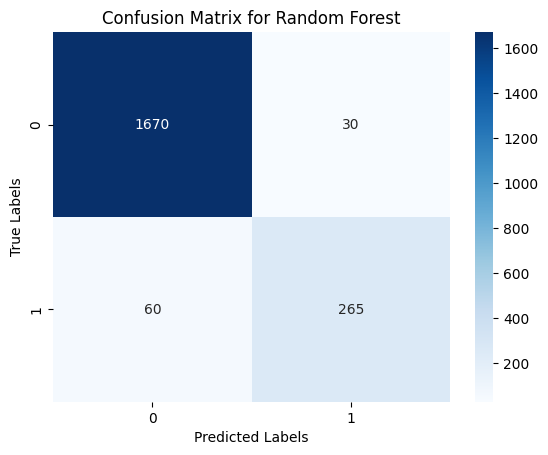

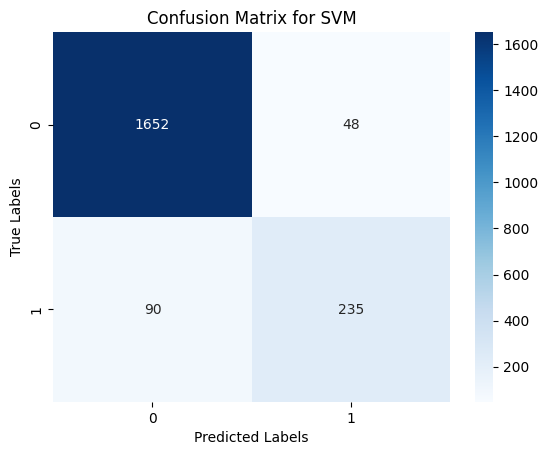

In [113]:
models = {
    "Lasso": final_model_lasso[-1],
    "Ridge": final_model_ridge[-1],
    'ElasticNet': final_model_elasticnet[-1],
    "XGBoost": final_model_xgboost[-1],
    "Random Forest": final_model_rf[-1],
    "SVM": final_models_svm[-1]
}

for model_name, model in models.items():
    
    predictions = model.predict(X_test_prep)

    cm = confusion_matrix(y_test, predictions)
    
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.savefig(f'figures/{model_name}_confusion_matrix.png', bbox_inches='tight', dpi=300)
    plt.show()

In [97]:
models = final_model_xgboost
feature_names = []

onehot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_fea)
ordinal_features = preprocessor.named_transformers_['ord'].get_feature_names_out(ord_fea)
feature_names.extend(onehot_features)
feature_names.extend(ordinal_features)
feature_names.extend(con_fea)
feature_names.extend(dis_fea)

print(feature_names)
print(len(feature_names))

feature_importances = []

for model in models:
    model.get_booster().feature_names = feature_names
    model_feature_importance = pd.DataFrame(model.get_booster().get_score(importance_type="gain"), index=[0])
    feature_importances.append(model_feature_importance)

feature_importance = pd.concat(feature_importances, ignore_index=True)

feature_importance.fillna(0, inplace=True)
feature_importance

['Gender_F', 'Gender_M', 'Marital_Status_Divorced', 'Marital_Status_Married', 'Marital_Status_Single', 'Marital_Status_Unknown', 'Education_Level', 'Income_Category', 'Card_Category', 'CLIENTNUM', 'Customer_Age', 'Months_on_book', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Dependent_count', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']
24


Gender_F  Gender_M  Marital_Status_Divorced  Marital_Status_Married  \
0  1.547430  1.358921                 1.492877                9.042426   
1  1.130760  1.038545                 0.895409               12.819653   
2  1.543641  0.917098                 1.163095                7.820752   
3  0.927087  1.344284                 1.577124                6.779634   
4  1.872563  1.981393                 2.217414                4.197324   

   Marital_Status_Single  Marital_Status_Unknown  Education_Level  \
0               3.931974                1.216149         3.707932   
1               3.895360                0.000000         2.632551   
2               4.153358                0.000000         3.160049   
3               0.000000                1.148926         3.256734   
4               7.070005                2.286730         5.305671   

   Income_Category  Card_Category  CLIENTNUM  ...  Avg_Open_To_Buy  \
0         2.243944       1.114966   1.763868  ...         2.256267   
1         1.478121       1.949647   1.455896  ...         2.507283   
2         1.221095       3.043861   2.140778  ...         3.482469   
3         1.880085       1.692807   1.114856  ...         2.604031   
4         3.494614       0.893130   2.561183  ...         4.266496   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0              5.326029        14.293210       18.114410            14.905684   
1              5.245705        11.832959       21.547714            11.754714   
2              7.575870        15.297106       30.669504            17.501129   
3              4.640746        11.001138       25.995375            13.001622   
4              6.415359        17.833160       21.000359            15.851185   

   Avg_Utilization_Ratio  Dependent_count  Total_Relationship_Count  \
0              10.436219         1.718243                 17.672497   
1               6.717004         2.195572                 21.744427   
2              10.276712         3.154728                 24.569881   
3               1.223374         1.230835                 17.527468   
4              21.969873         1.761290                 20.600580   

   Months_Inactive_12_mon  Contacts_Count_12_mon  
0               10.929376               6.692034  
1                8.753317               4.882099  
2               13.753675               7.330432  
3               11.794694               4.140480  
4               10.369741               7.065435  

[5 rows x 24 columns]

In [122]:
importance = feature_importance.mean().sort_values(ascending= False)
features = importance.index.tolist()
error = [np.std(feature_importance[feature]) for feature in features]

<Figure size 640x480 with 0 Axes>

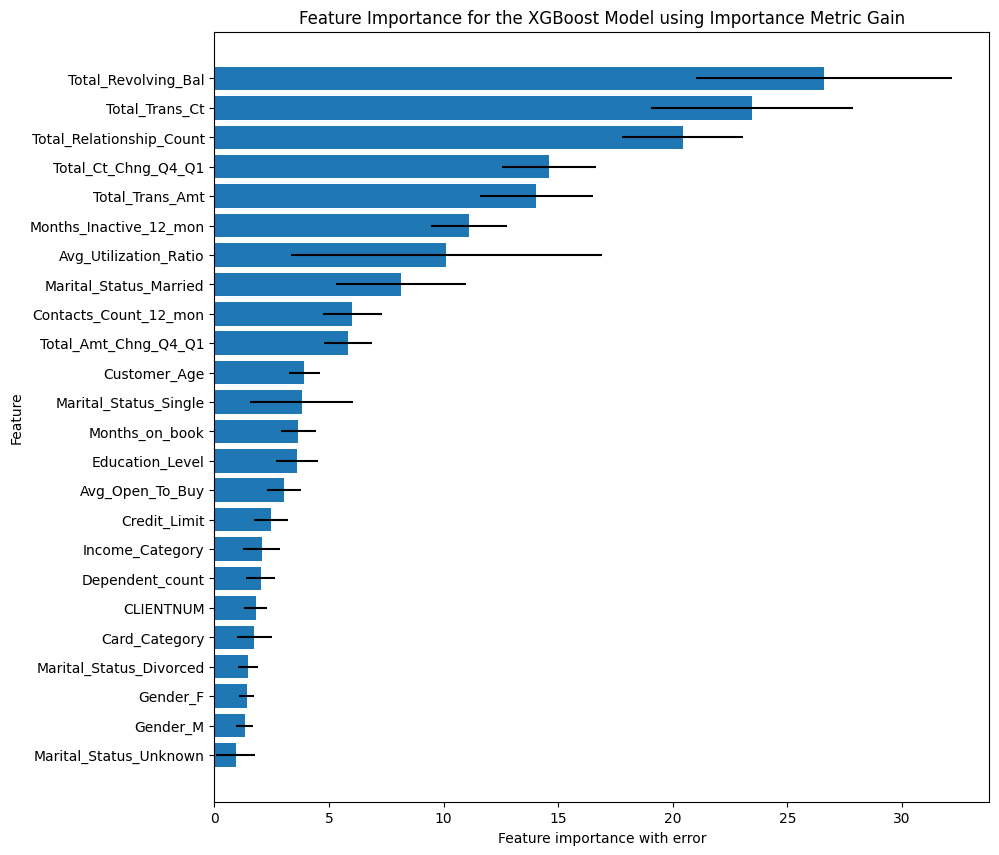

In [129]:
# Plot the feature importances with error over 5 random states. 
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot()
ax.barh(features,importance, xerr=error, align='center')
ax.invert_yaxis() 
ax.set_xlabel('Feature importance with error')
ax.set_ylabel('Feature')
plt.savefig(f'figures/global_importance.png', bbox_inches='tight', dpi=300)
plt.title('Feature Importance for the XGBoost Model using Importance Metric Gain')
plt.show()

In [124]:
explainer = shap.TreeExplainer(final_model_xgboost[-1]) 
shap_values = explainer.shap_values(X_test_prep) 

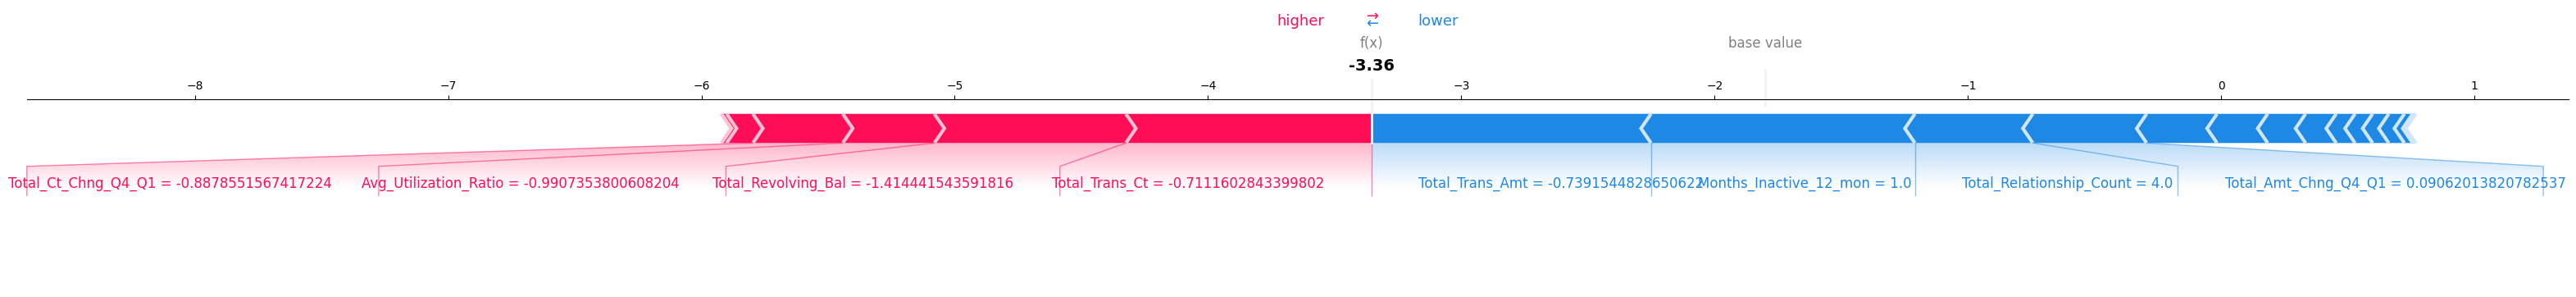

In [125]:
# Explain a point
seed(1)
index_neg = sample(np.where(y_test == 0)[0].tolist(),1)

shap.force_plot(explainer.expected_value, shap_values[index_neg,:], features = X_test_prep[index_neg,:],feature_names = feature_names,
                        show = False,matplotlib=True,figsize=(40,3))
fig_neg = plt.gcf()
fig_neg

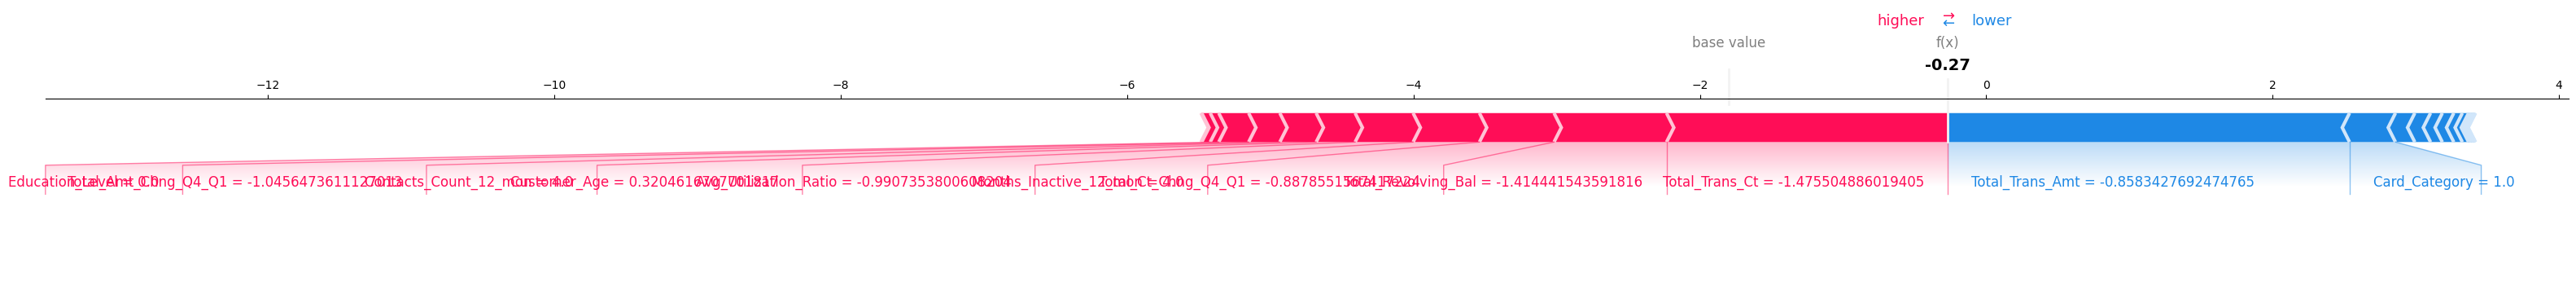

In [126]:
index_pos = sample(np.where(y_test == 1)[0].tolist(),1)
shap.force_plot(explainer.expected_value, shap_values[index_pos,:], features = X_test_prep[index_pos,:],feature_names = feature_names,
               show = False,matplotlib=True,figsize=(40,3))
fig_neg = plt.gcf()
fig_neg

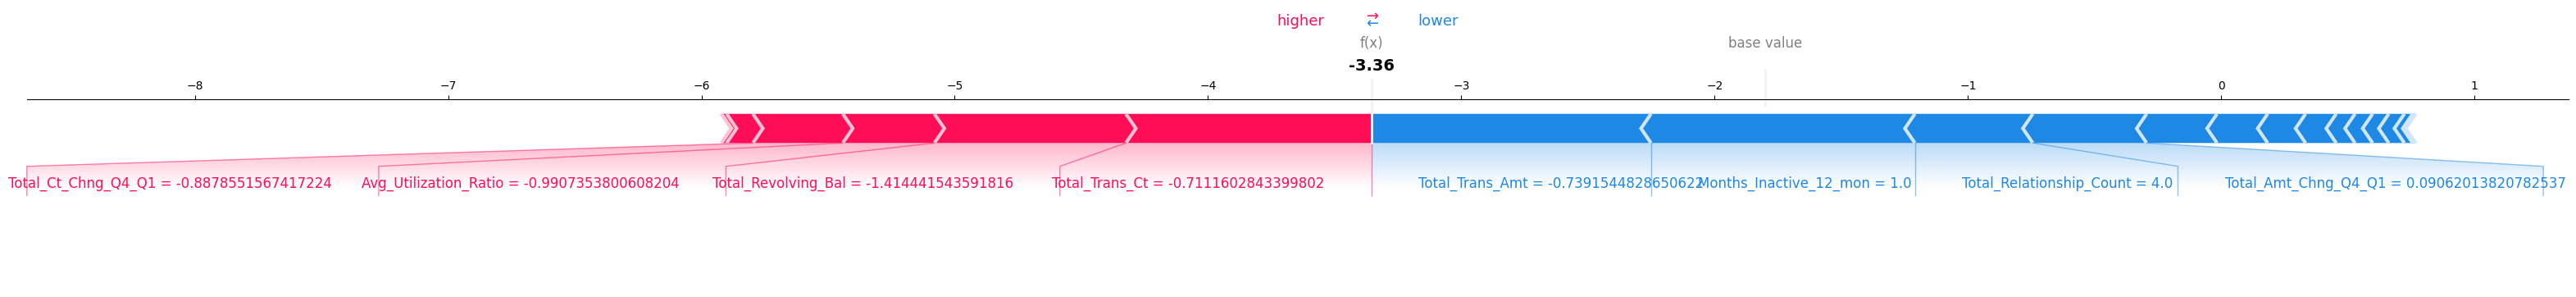

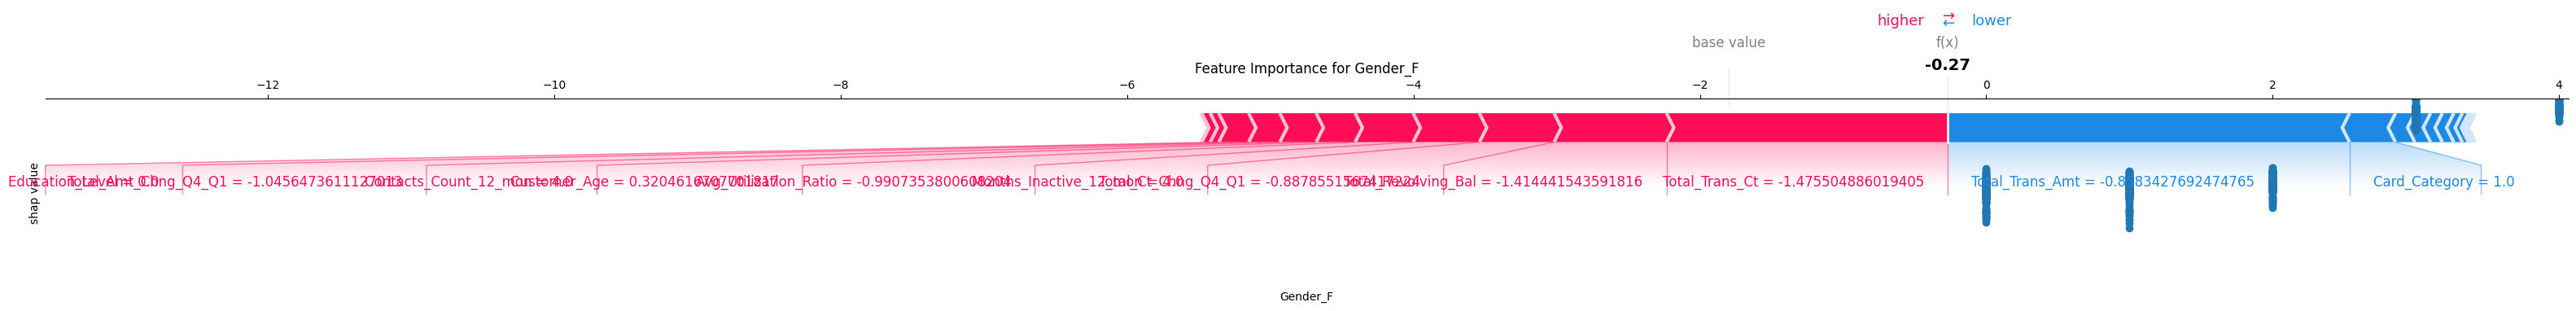

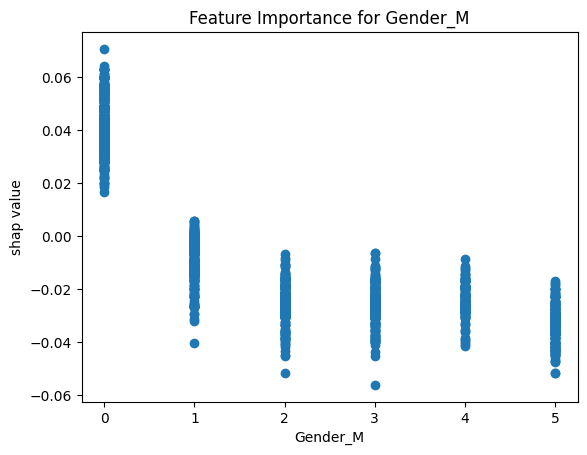

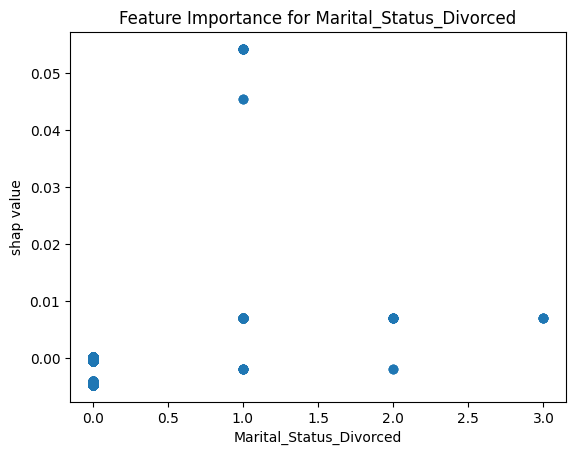

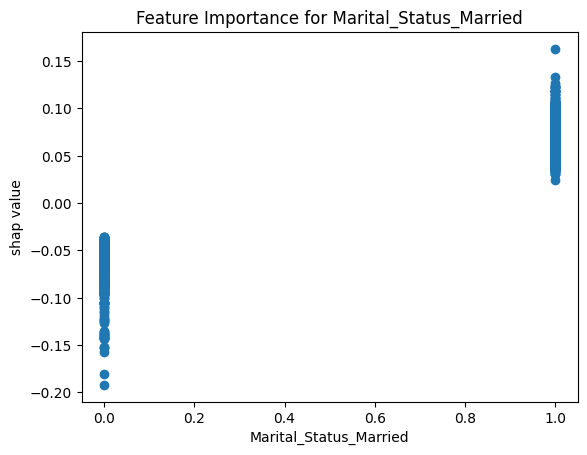

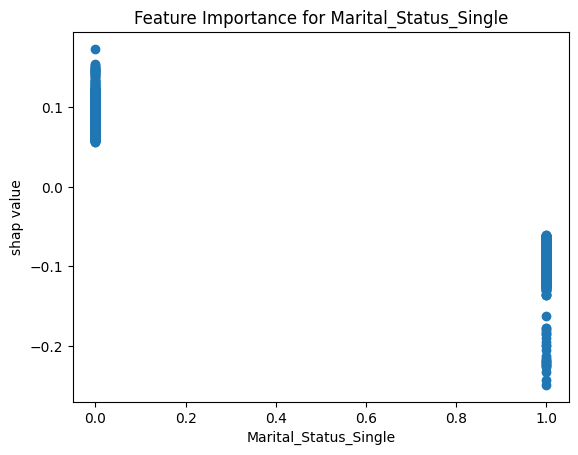

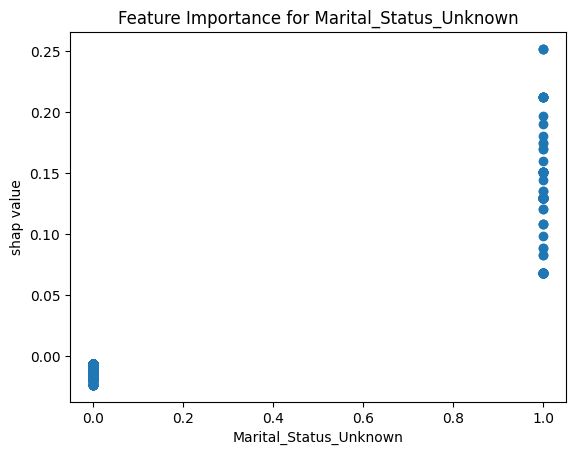

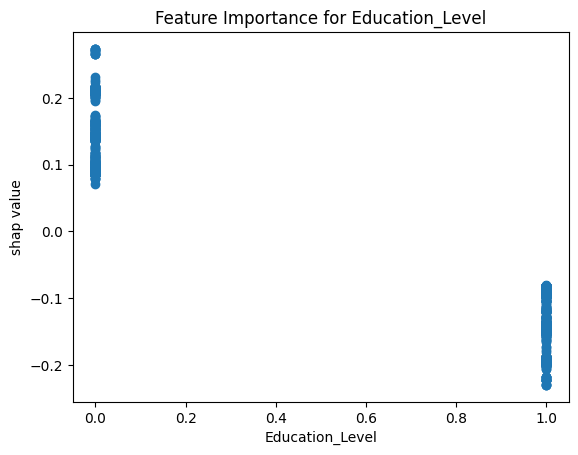

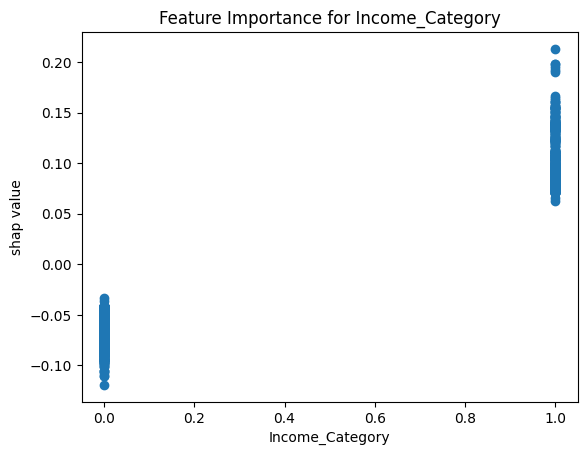

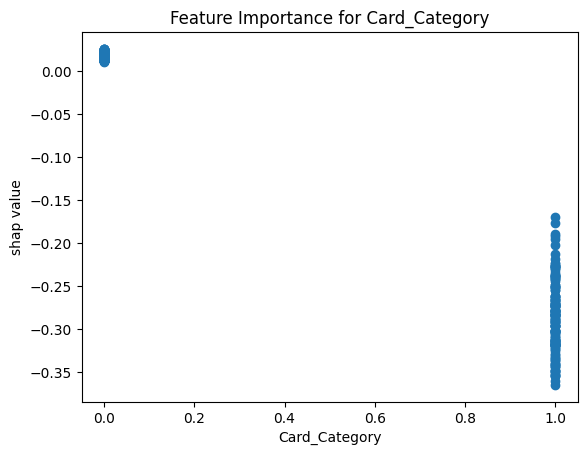

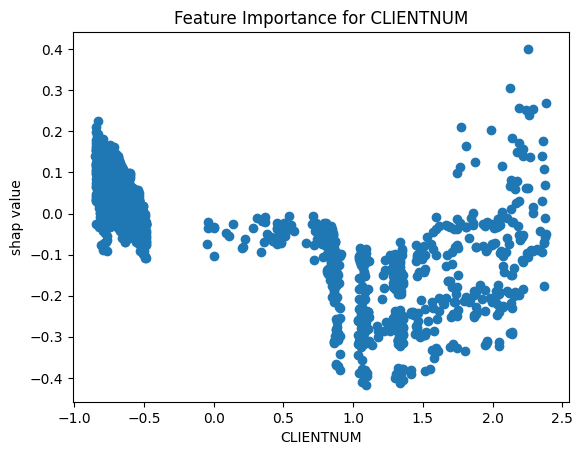

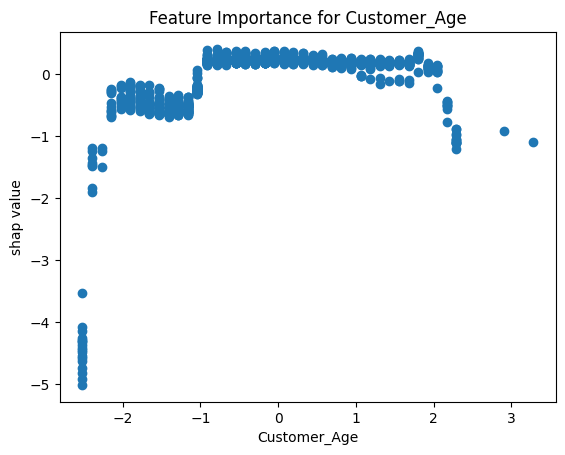

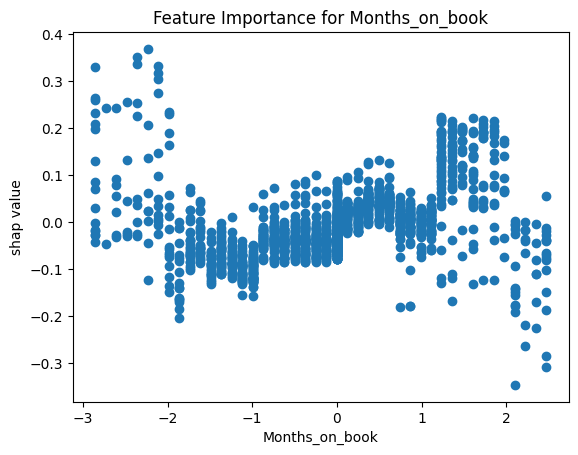

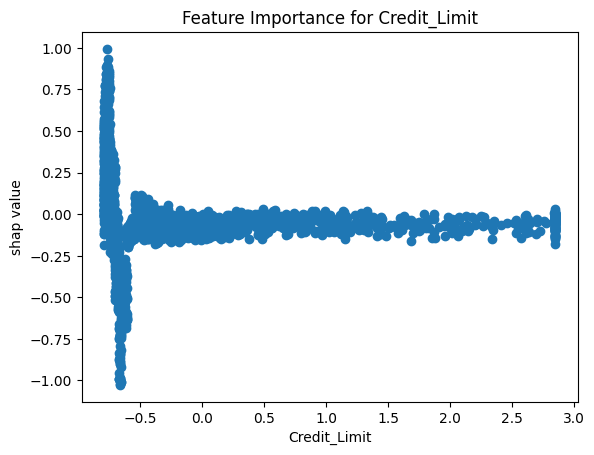

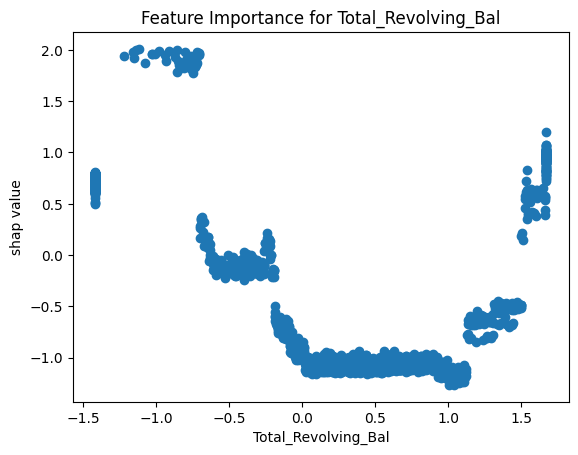

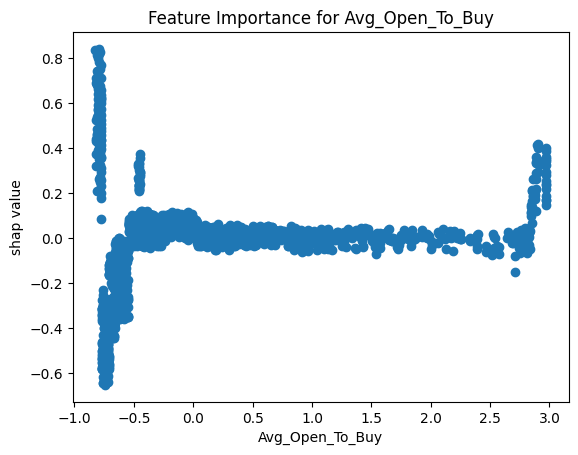

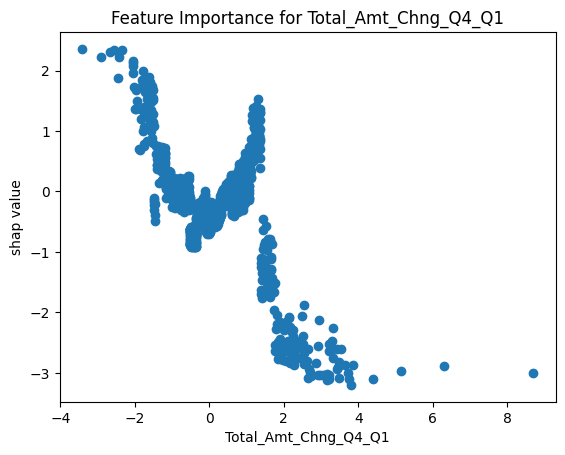

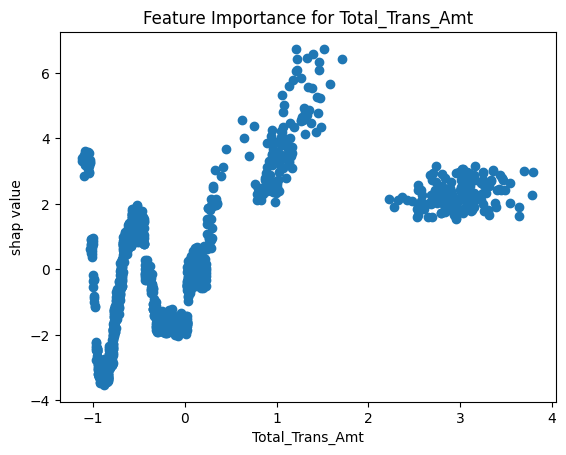

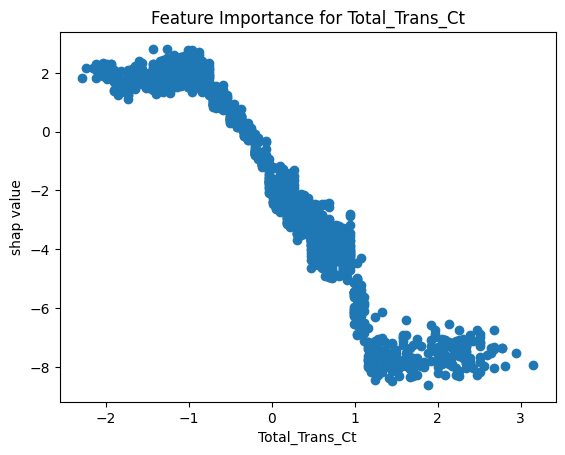

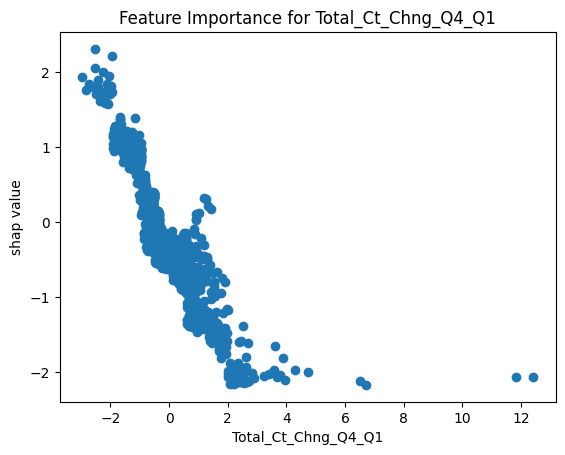

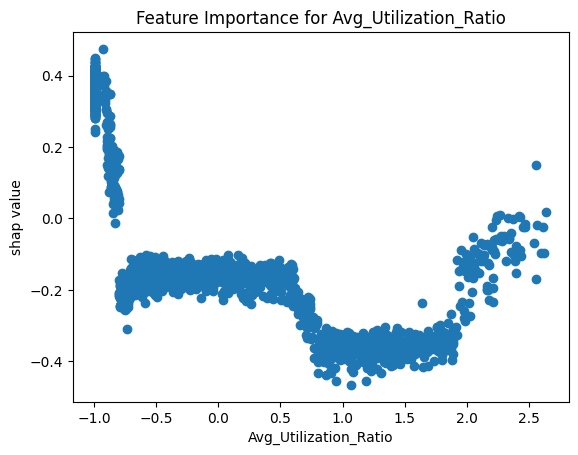

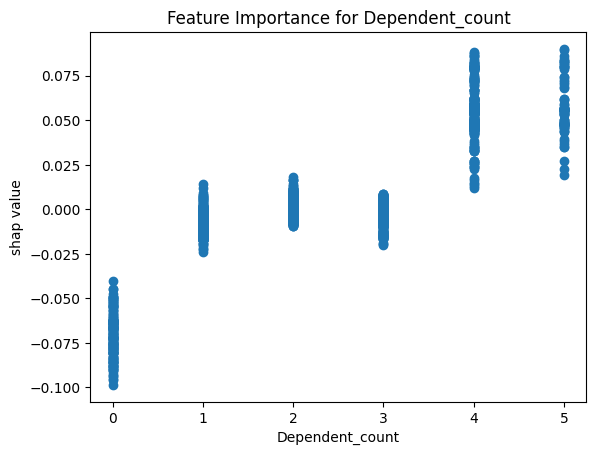

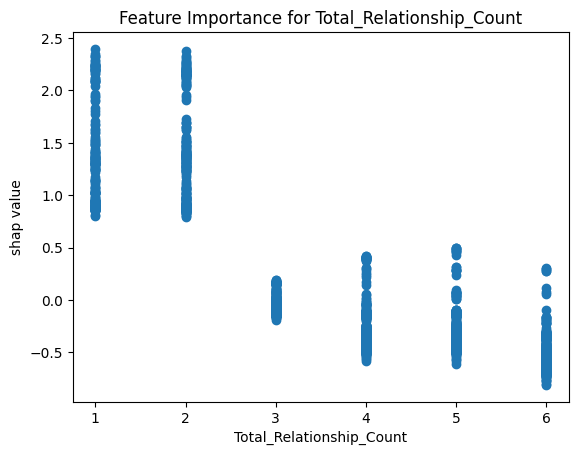

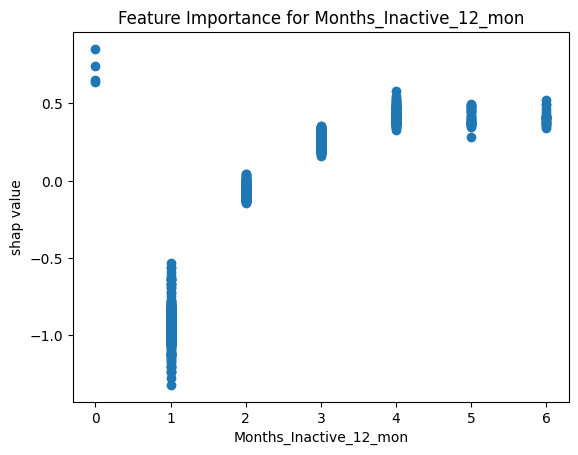

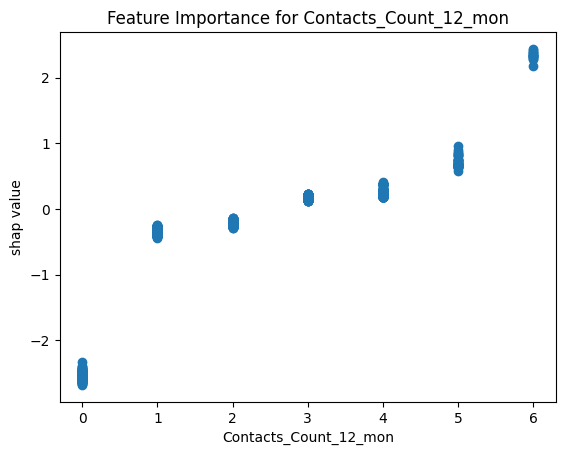

In [127]:
# Explain a feature 
for ftr in feature_names:
    indx = np.argwhere(np.array(feature_names)==ftr)
    plt.scatter(X_test_prep[:,indx],shap_values[:,indx])
    plt.ylabel('shap value')
    plt.xlabel(ftr)
    plt.title(f'Feature Importance for {ftr}')
    plt.savefig(f"figures/{ftr}_shap_plot.png", bbox_inches='tight', dpi=300)
    plt.show()

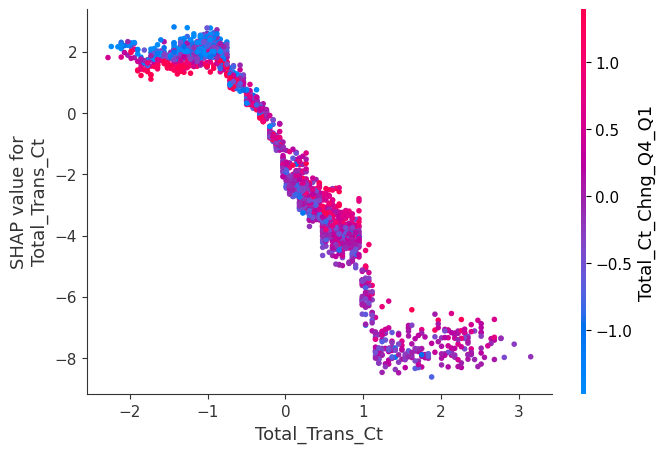

In [130]:
shap.dependence_plot('Total_Trans_Ct', shap_values, X_test_prep, feature_names=feature_names)

# Summary

It's important to consider the relationships between pairs of features, as well as among multiple features, to enhance interpretability. For instance, there are noticeable similarities in the scatter plots of SHAP values and feature values, particularly between 'Total_Trans_Ct' and 'Total_Ct_Change_Q4_Q1', and 'Avg_Open_To_Buy' and 'Credit_Limit.' These pairs of features have strong associations: 'Total_Trans_Ct' and 'Total_Ct_Change_Q4_Q1' are both linked to transaction counts, while the sum of a customer's average available credit ('Avg_Open_To_Buy') and the average amount charged to their credit card aligns with their 'Credit_Limit.' Moreover, the relationship between 'Avg_Open_To_Buy' and 'Credit_Limit' suggests the potential for a new feature representing the average amount customers pay using their credit card, which could enhance our model's predictive accuracy.

Beyond feature engineering, two additional strategies might improve model performance, as indicated by prior studies. Firstly, employing the LightGBM model could be beneficial, given its documented success in achieving approximately a 95.7% F2 score. Secondly, gathering more data on "Attrited Customers" could be advantageous. Previous findings indicate that using the SMOTE technique to oversample the minority class can boost model performance.

Finally, careful consideration of the evaluation score is crucial. The actual cost of misclassifying an attrited customer as existing might be more significant than mis-predicting an existing customer as attrited. Balancing these potential losses is key to refining the model's effectiveness.